# Compare N2 decadal change in the global ocean using EasyOcean data

- Use configurated data from https://cchdo.ucsd.edu/products/goship-easyocean
- Use gridded data (.mat) with stratification calculations (STrun.m; updated grid_data_pressure.m)


In [1]:
%matplotlib inline
import numpy as np
import xarray as xr
import scipy.io as sio
import os
import matplotlib.pyplot as plt

import topo as topo

In [2]:
def plot_N2_trend_z(data_N2_trend, ax, dl, dz, vrange=[-1e-7,1e-7], yrange=[6000, 0]):
    from matplotlib import cm
    import matplotlib as mpl

    norm = mpl.colors.SymLogNorm(linthresh=5e-8, vmax=vrange[-1], vmin=vrange[0], base=10)

    ax.pcolormesh(np.hstack([data_N2_trend.LL_st.data,data_N2_trend.LL_st.data[-1]+dl]), 
              np.hstack([data_N2_trend.z_N2.data - dz/2, data_N2_trend.z_N2.data[-1] + dz/2]), 
              data_N2_trend.trend_N2_mean.T, vmax=vrange[-1], vmin=vrange[0], cmap=cm.PiYG_r, norm=norm)
    # data_N2_trend.trend_N2_CI[:,:,1].plot.contour(ax=ax, y='z_N2', levels=[0], colors='grey')
    
    for j in range(len(data_N2_trend.LL_st)):
        for k in range(len(data_N2_trend.z_N2)):
            if data_N2_trend.trend_N2_CI[j,k,1] < 0:
#                 ax.plot(data_N2_trend.LL_st[j], data_N2_trend.z_N2[k], 'kp')
                ax.plot([data_N2_trend.LL_st[j], data_N2_trend.LL_st[j]+dl/2], [data_N2_trend.z_N2[k]-dz/4, data_N2_trend.z_N2[k]+dz/2], 'k-', lw=.5)
                ax.plot([data_N2_trend.LL_st[j]+dl/2, data_N2_trend.LL_st[j]+dl], [data_N2_trend.z_N2[k]-dz/2, data_N2_trend.z_N2[k]+dz/4], 'k-', lw=.5)
            if data_N2_trend.trend_N2_CI[j,k,0] > 0:
                ax.plot([data_N2_trend.LL_st[j]+dl/2, data_N2_trend.LL_st[j]], [data_N2_trend.z_N2[k]-dz/2, data_N2_trend.z_N2[k]+dz/4], 'k-', lw=.5)
                ax.plot([data_N2_trend.LL_st[j]+dl, data_N2_trend.LL_st[j]+dl/2], [data_N2_trend.z_N2[k]-dz/4, data_N2_trend.z_N2[k]+dz/2], 'k-', lw=.5)
    ax.set_ylim(yrange)
    
    
    
def plot_N2_trend_sig(data_N2_trend, ax, dl, dsig, vrange=[-1e-7,1e-7], yrange=[46.13, 46.01]):
    from matplotlib import cm
    import matplotlib as mpl

    norm = mpl.colors.SymLogNorm(linthresh=5e-8, vmax=vrange[-1], vmin=vrange[0], base=10)

    ax.pcolormesh(np.hstack([data_N2_trend.LL_st.data,data_N2_trend.LL_st.data[-1]+dl]), 
              np.hstack([data_N2_trend.z_N2.data - dsig/2, data_N2_trend.z_N2.data[-1] + dsig/2]), 
              data_N2_trend.trend_N2_mean.T, vmax=vrange[-1], vmin=vrange[0], cmap=cm.PiYG_r, norm=norm)
    # data_N2_trend.trend_N2_CI[:,:,1].plot.contour(ax=ax, y='z_N2', levels=[0], colors='grey')
    
    for j in range(len(data_N2_trend.LL_st)):
        for k in range(len(data_N2_trend.z_N2)):
            if data_N2_trend.trend_N2_CI[j,k,1] < 0:
                ax.plot([data_N2_trend.LL_st[j], data_N2_trend.LL_st[j]+dl/2], [data_N2_trend.z_N2[k]-dsig/4, data_N2_trend.z_N2[k]+dsig/2], 'k-', lw=.5)
                ax.plot([data_N2_trend.LL_st[j]+dl/2, data_N2_trend.LL_st[j]+dl], [data_N2_trend.z_N2[k]-dsig/2, data_N2_trend.z_N2[k]+dsig/4], 'k-', lw=.5)
            if data_N2_trend.trend_N2_CI[j,k,0] > 0:
                ax.plot([data_N2_trend.LL_st[j]+dl/2, data_N2_trend.LL_st[j]], [data_N2_trend.z_N2[k]-dsig/2, data_N2_trend.z_N2[k]+dsig/4], 'k-', lw=.5)
                ax.plot([data_N2_trend.LL_st[j]+dl, data_N2_trend.LL_st[j]+dl/2], [data_N2_trend.z_N2[k]-dsig/4, data_N2_trend.z_N2[k]+dsig/2], 'k-', lw=.5)
    ax.set_ylim(yrange)


In [3]:
def loc_dep_sec(acquisition, method, datafilepath):
    """method = 1: lon section
       method = 0, lat section """
    # station_loc[occupation, lon/lat, station]

    acqui_path = datafilepath + acquisition + '/'
    print(10*"-", acquisition, 10*"-")
    for filename_ in os.listdir(acqui_path):
        if (filename_.endswith(".mat")):  # mat data
            data0 = sio.loadmat(acqui_path + filename_,
                                squeeze_me=True, struct_as_record=False)
            span = np.zeros(len(data0['D_reported']),)
            
            if method:
                for i in range(len(span)):
                    if i == 0:
                        loc = data0['D_reported'][i].latlist
                        loc_ = data0['D_reported'][i].lonlist
                        depth = data0['D_reported'][i].deplist
                    else:
                        loc = np.hstack([loc, data0['D_reported'][i].latlist])
                        loc_ = np.hstack([loc_, data0['D_reported'][i].lonlist])
                        depth = np.hstack([depth, data0['D_reported'][i].deplist])
            else:
                for i in range(len(span)):
                    if i == 0:
                        loc = data0['D_reported'][i].lonlist
                        loc_ = data0['D_reported'][i].latlist
                        depth = data0['D_reported'][i].deplist
                    else:
                        loc = np.hstack([loc, data0['D_reported'][i].lonlist])
                        loc_ = np.hstack([loc, data0['D_reported'][i].latlist])
                        depth = np.hstack([depth, data0['D_reported'][i].deplist])
                        
            ind = np.argsort(loc)
            depth = depth[ind]
            loc = loc[ind]
            loc_ = loc_[ind]
    
    
    return loc, depth#, loc_

In [4]:
def lat_fronts(fronts, lon):
    from scipy.interpolate import interp1d
    f = interp1d(fronts['stf'][:,0], fronts['stf'][:,1], bounds_error=False, fill_value=np.nan)
    stf = f(lon)

    f = interp1d(fronts['saf'][:,0], fronts['saf'][:,1], bounds_error=False, fill_value=np.nan)
    saf = f(lon)

    f = interp1d(fronts['saccf'][:,0], fronts['saccf'][:,1], bounds_error=False, fill_value=np.nan)
    saccf = f(lon)

    f = interp1d(fronts['pf'][:,0], fronts['pf'][:,1], bounds_error=False, fill_value=np.nan)
    pf = f(lon)

    f = interp1d(fronts['sbdy'][:,0], fronts['sbdy'][:,1], bounds_error=False, fill_value=np.nan)
    sbdy = f(lon)
    
    fronts_ = np.stack([stf, saf, saccf, pf, sbdy]) 
    fronts_names = ['STF', 'SAF', 'SACCF', 'PF', 'SBDY']
    
    return fronts_, fronts_names

## Parameters

In [5]:
# path to WOCE read trend results
resultfilepath = '../results/'
datafilepath = '/Users/stan/Desktop/WORK/DATA/GOSHIP/EasyOcean/gridded/'
datafilepath_sec = '/Users/stan/Desktop/WORK/DATA/GOSHIP/EasyOcean/reported/'
# path to saved data
outfilepath = '../figure/'

param_plot = {"z1_up": 2000,
              "z2_up": 0,
              "z1_lw": 6000,
              "z2_lw": 2000,
              "sig1_up": 45.65,
              "sig2_up": 43,
              "sig1_lw": 46.25,
              "sig2_lw": 45.95,
              "vlim1": [-1e-7,1e-7],
              "vlim2": [-1e-7,1e-7],
              "vlim_factor1": [.8,1.2],
              "vlim_factor2": [.8,1.2],
            }
param_pic = {"fontsize": [14, 20, 25],
             "linewidth": [1, 2.5, 4],
             "color": ['b', 'c', 'r', 'hotpink', 'gold', 'k']
            }

# load bathymetry and create a DataArray object
Topo = topo.read_topo('../data/', 'ETOPO1_Bed_g_geotiff.tif', 0)

In [6]:
# load acc front information
fronts = sio.loadmat('../data/fronts.mat', squeeze_me=True, struct_as_record=False)
fronts.keys()

dict_keys(['__header__', '__version__', '__globals__', 'stf', 'saf', 'saccf', 'pf', 'sbdy'])

In [7]:
# load sec location info
import pickle
loc_info = open(resultfilepath + 'EasyOcean_location.obj', 'rb')
loc = pickle.load(loc_info)
loc_info.close()

section_name = loc["lon_sec"] + loc["lat_sec"]
loc['loc_lon_sec'][loc['loc_lon_sec']>180] -= 360
section_loc = np.hstack((loc['loc_lon_sec'], loc['loc_lat_sec']))
method = np.hstack((np.ones(loc['loc_lon_sec'].shape), np.zeros(loc['loc_lat_sec'].shape))).astype('bool')

## Atlantic Ocean

### 1. selected longitudial sections

In [8]:
# longitudial sections
lon_sec = ['A16-A23', 'A13', 'A12']
method_sec = 1
fronts_colors = ['b', 'c', 'r', 'hotpink', 'gold']   


/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/4202119098.py:7: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  ax.pcolormesh(np.hstack([data_N2_trend.LL_st.data,data_N2_trend.LL_st.data[-1]+dl]),
/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/368530954.py:9: RuntimeWarning: Mean of empty slice
  cs = ax[i].contour(Data.LL, Data.z_N2, np.nanmean(Data.Sig4_N2,axis=0).T, levels=np.arange(param_plot['sig1_up'], param_plot['sig1_lw'], .05),colors='k',linewidth='.5')
/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/368530954.py:9: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cs = ax[i].contour(Data.LL, Data.z_N2, np.nanmean(Data.Sig4_N2,axis=0).T, levels=np.arange(param_plot['sig1_up'], param_plot['sig1_lw'], .05),colors='k',linewidth='.5')


---------- A16-A23 ----------


/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/4202119098.py:7: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  ax.pcolormesh(np.hstack([data_N2_trend.LL_st.data,data_N2_trend.LL_st.data[-1]+dl]),
/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/368530954.py:9: RuntimeWarning: Mean of empty slice
  cs = ax[i].contour(Data.LL, Data.z_N2, np.nanmean(Data.Sig4_N2,axis=0).T, levels=np.arange(param_plot['sig1_up'], param_plot['sig1_lw'], .05),colors='k',linewidth='.5')
/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/368530954.py:9: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cs = ax[i].contour(Data.LL, Data.z_N2, np.nanmean(Data.Sig4_N2,axis=0).T, levels=np.arange(param_plot['sig1_up'], param_plot['sig1_lw'], .05),colors='k',linewidth='.5')


---------- A13 ----------


/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/4202119098.py:7: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  ax.pcolormesh(np.hstack([data_N2_trend.LL_st.data,data_N2_trend.LL_st.data[-1]+dl]),
/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/368530954.py:9: RuntimeWarning: Mean of empty slice
  cs = ax[i].contour(Data.LL, Data.z_N2, np.nanmean(Data.Sig4_N2,axis=0).T, levels=np.arange(param_plot['sig1_up'], param_plot['sig1_lw'], .05),colors='k',linewidth='.5')
/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/368530954.py:9: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cs = ax[i].contour(Data.LL, Data.z_N2, np.nanmean(Data.Sig4_N2,axis=0).T, levels=np.arange(param_plot['sig1_up'], param_plot['sig1_lw'], .05),colors='k',linewidth='.5')


---------- A12 ----------


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


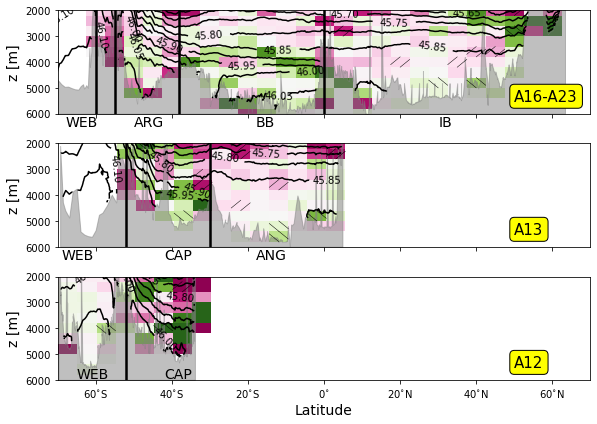

In [9]:
fig, ax = plt.subplots(nrows=len(lon_sec), ncols=1, figsize=(140/100*6, len(lon_sec)*2), sharex=True)
for i in range(len(lon_sec)):
    acquisition = lon_sec[i]
    Data = xr.open_dataset(datafilepath + acquisition.lower() + ".nc")
    Data_trend = xr.open_dataset(datafilepath + acquisition.lower() + "_trend.nc")
    Data_trend_sig4 = xr.open_dataset(datafilepath+ acquisition.lower() + "_sig4_trend.nc")
    
    plot_N2_trend_z(Data_trend, ax[i], np.diff(Data_trend.LL_st)[0], np.diff(Data_trend.z_N2)[0], vrange=param_plot['vlim1'], yrange=[param_plot['z1_lw'], param_plot['z1_up']])
    cs = ax[i].contour(Data.LL, Data.z_N2, np.nanmean(Data.Sig4_N2,axis=0).T, levels=np.arange(param_plot['sig1_up'], param_plot['sig1_lw'], .05),colors='k',linewidth='.5')
    ax[i].clabel(cs, cs.levels, fmt ='%1.2f',  inline=True, fontsize=10)        
#     ax[i].set_title(acquisition, fontsize=15)
    ax[i].text(50, 5500, acquisition, fontsize=15, bbox=dict(boxstyle='round', facecolor='yellow'))
    ax[i].set_ylabel('z [m]', fontsize=14)
    ax[i].set_xlim([-70, 70])
    ax[i].set_xticks(np.arange(-60, 60+1, 20))
    if i == len(lon_sec)-1:
#         ax[i].set_xticklabels(['','','','','','',''])
        ax[i].set_xticklabels(['60$^{\circ}$S','40$^{\circ}$S','20$^{\circ}$S','0$^{\circ}$',
                            '20$^{\circ}$N','40$^{\circ}$N','60$^{\circ}$N'])
        ax[i].set_xlabel('Latitude', fontsize=14)
        
    if lon_sec[i].startswith('S'):
        loc_ll, dep_ll = loc_dep_sec(lon_sec[i], method_sec, datafilepath_sec+'southern/')
    else:
        loc_ll, dep_ll = loc_dep_sec(lon_sec[i], method_sec, datafilepath_sec+'atlantic/')
#     
    ax[i].fill_between(loc_ll, dep_ll, param_plot['z1_lw'], color='.5', alpha=.5)
    
#     fronts_, fronts_names = lat_fronts(fronts, section_loc[section_name.index(lon_sec[i])])
#     for j in range(len(fronts_)):
#         ax[i].plot([fronts_[j], fronts_[j]], [2000, 6000], c=fronts_colors[j], label=fronts_names[j])

ax[0].text(-68, 6500, 'WEB', fontsize=14)
ax[0].plot([-60, -60], [2000, 6000], 'k', lw=2.5)
ax[0].plot([-55, -55], [2000, 6000], 'k', lw=2.5)
ax[0].text(-50, 6500, 'ARG', fontsize=14)
ax[0].plot([-38, -38], [2000, 6000], 'k', lw=2.5)
ax[0].text(-18, 6500, 'BB', fontsize=14)
ax[0].plot([0, 0], [2000, 6000], 'k', lw=2.5)
ax[0].text(30, 6500, 'IB', fontsize=14)

ax[1].text(-69, 6500, 'WEB', fontsize=14)
ax[1].plot([-52, -52], [2000, 6000], 'k', lw=2.5)
ax[1].text(-42, 6500, 'CAP', fontsize=14)
ax[1].plot([-30, -30], [2000, 6000], 'k', lw=2.5)
ax[1].text(-18, 6500, 'ANG', fontsize=14)

ax[-1].text(-65, 5950, 'WEB', fontsize=14)
ax[-1].plot([-52, -52], [2000, 6000], 'k', lw=2.5)
# ax[-1].text(-52, 5950, 'AGU', fontsize=12)
# ax[-1].plot([-45, -45], [2000, 6000], 'k', lw=2.5)
ax[-1].text(-42, 5950, 'CAP', fontsize=14)

plt.tight_layout()
plt.savefig(outfilepath+ 'Atlantic_meridional_selected_N2trend.jpeg', dpi=300)
plt.savefig(outfilepath+ 'Atlantic_meridional_selected_N2trend.eps')

/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/4202119098.py:31: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  ax.pcolormesh(np.hstack([data_N2_trend.LL_st.data,data_N2_trend.LL_st.data[-1]+dl]),
/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/4202119098.py:31: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  ax.pcolormesh(np.hstack([data_N2_trend.LL_st.data,data_N2_trend.LL_st.data[-1]+dl]),
/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/4202119098.py:31: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two min

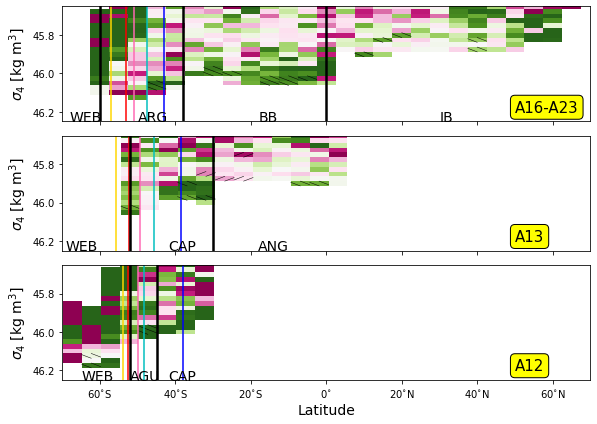

In [10]:
fig, ax = plt.subplots(nrows=len(lon_sec), ncols=1, figsize=(140/100*6, len(lon_sec)*2), sharex=True)
for i in range(len(lon_sec)):
    acquisition = lon_sec[i]
    Data_trend = xr.open_dataset(datafilepath + acquisition.lower() + "_trend.nc")
    Data_trend_sig4 = xr.open_dataset(datafilepath+ acquisition.lower() + "_sig4_trend.nc")
    
    plot_N2_trend_sig(Data_trend_sig4, ax[i], np.diff(Data_trend_sig4.LL_st)[0], np.diff(Data_trend_sig4.z_N2)[0], vrange=param_plot['vlim1'], yrange=[param_plot['sig1_lw'], param_plot['sig1_up']])
#     ax[i].set_title(acquisition, fontsize=15)
    ax[i].text(50, 46.2, acquisition, fontsize=15, bbox=dict(boxstyle='round', facecolor='yellow'))
    ax[i].set_ylabel('$\sigma_4$ [kg m$^3$]', fontsize=14)
    ax[i].set_xlim([-70, 70])
    ax[i].set_xticks(np.arange(-60, 60+1, 20))
    if i == len(lon_sec)-1:
        ax[i].set_xticklabels(['60$^{\circ}$S','40$^{\circ}$S','20$^{\circ}$S','0$^{\circ}$',
                            '20$^{\circ}$N','40$^{\circ}$N','60$^{\circ}$N'])
        ax[i].set_xlabel('Latitude', fontsize=14)
        
    fronts_, fronts_names = lat_fronts(fronts, section_loc[section_name.index(lon_sec[i])])
    for j in range(len(fronts_)):
        ax[i].plot([fronts_[j], fronts_[j]], [param_plot['sig1_lw'], param_plot['sig1_up']], c=fronts_colors[j], label=fronts_names[j])
        
ax[0].text(-68, param_plot['sig1_lw'], 'WEB', fontsize=14)
ax[0].plot([-60, -60], [param_plot['sig1_lw'], param_plot['sig1_up']], 'k', lw=2.5)
ax[0].text(-50, param_plot['sig1_lw'], 'ARG', fontsize=14)
ax[0].plot([-38, -38], [param_plot['sig1_lw'], param_plot['sig1_up']], 'k', lw=2.5)
ax[0].text(-18,  param_plot['sig1_lw'], 'BB', fontsize=14)
ax[0].plot([0, 0], [param_plot['sig1_lw'], param_plot['sig1_up']], 'k', lw=2.5)
ax[0].text(30, param_plot['sig1_lw'], 'IB', fontsize=14)

ax[1].text(-69, param_plot['sig1_lw'], 'WEB', fontsize=14)
ax[1].plot([-52, -52], [param_plot['sig1_lw'], param_plot['sig1_up']], 'k', lw=2.5)
ax[1].text(-42, param_plot['sig1_lw'], 'CAP', fontsize=14)
ax[1].plot([-30, -30], [param_plot['sig1_lw'], param_plot['sig1_up']], 'k', lw=2.5)
ax[1].text(-18, param_plot['sig1_lw'], 'ANG', fontsize=14)

ax[-1].text(-65, param_plot['sig1_lw'], 'WEB', fontsize=14)
ax[-1].plot([-52, -52], [param_plot['sig1_lw'], param_plot['sig1_up']], 'k', lw=2.5)
ax[-1].text(-52, param_plot['sig1_lw'], 'AGU', fontsize=14)
ax[-1].plot([-45, -45], [param_plot['sig1_lw'], param_plot['sig1_up']], 'k', lw=2.5)
ax[-1].text(-42, param_plot['sig1_lw'], 'CAP', fontsize=14)

plt.tight_layout()
plt.savefig(outfilepath+ 'Atlantic_meridional_selected_N2trend_sigma.jpeg', dpi=300)
plt.savefig(outfilepath+ 'Atlantic_meridional_selected_N2trend_sigma.eps')

### 1*. longitudial sections

In [11]:
lon_sec = ['SR01', 'A22', 'A20', 'AR07W', 'A16-A23', 'A13', 'A12']
method_sec = 1

/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/4202119098.py:7: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  ax.pcolormesh(np.hstack([data_N2_trend.LL_st.data,data_N2_trend.LL_st.data[-1]+dl]),
/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/835587882.py:9: RuntimeWarning: Mean of empty slice
  cs = ax[i].contour(Data.LL, Data.z_N2, np.nanmean(Data.Sig4_N2,axis=0).T, levels=np.arange(param_plot['sig1_up'], param_plot['sig1_lw'], .05),colors='k',linewidth='.5')
/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/835587882.py:9: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cs = ax[i].contour(Data.LL, Data.z_N2, np.nanmean(Data.Sig4_N2,axis=0).T, levels=np.arange(param_plot['sig1_up'], param_plot['sig1_lw'], .05),colors='k',linewidth='.5')


---------- SR01 ----------


/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/4202119098.py:7: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  ax.pcolormesh(np.hstack([data_N2_trend.LL_st.data,data_N2_trend.LL_st.data[-1]+dl]),
/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/835587882.py:9: RuntimeWarning: Mean of empty slice
  cs = ax[i].contour(Data.LL, Data.z_N2, np.nanmean(Data.Sig4_N2,axis=0).T, levels=np.arange(param_plot['sig1_up'], param_plot['sig1_lw'], .05),colors='k',linewidth='.5')
/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/835587882.py:9: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cs = ax[i].contour(Data.LL, Data.z_N2, np.nanmean(Data.Sig4_N2,axis=0).T, levels=np.arange(param_plot['sig1_up'], param_plot['sig1_lw'], .05),colors='k',linewidth='.5')


---------- A22 ----------


/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/4202119098.py:7: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  ax.pcolormesh(np.hstack([data_N2_trend.LL_st.data,data_N2_trend.LL_st.data[-1]+dl]),
/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/835587882.py:9: RuntimeWarning: Mean of empty slice
  cs = ax[i].contour(Data.LL, Data.z_N2, np.nanmean(Data.Sig4_N2,axis=0).T, levels=np.arange(param_plot['sig1_up'], param_plot['sig1_lw'], .05),colors='k',linewidth='.5')
/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/835587882.py:9: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cs = ax[i].contour(Data.LL, Data.z_N2, np.nanmean(Data.Sig4_N2,axis=0).T, levels=np.arange(param_plot['sig1_up'], param_plot['sig1_lw'], .05),colors='k',linewidth='.5')


---------- A20 ----------


/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/4202119098.py:7: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  ax.pcolormesh(np.hstack([data_N2_trend.LL_st.data,data_N2_trend.LL_st.data[-1]+dl]),
/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/835587882.py:9: RuntimeWarning: Mean of empty slice
  cs = ax[i].contour(Data.LL, Data.z_N2, np.nanmean(Data.Sig4_N2,axis=0).T, levels=np.arange(param_plot['sig1_up'], param_plot['sig1_lw'], .05),colors='k',linewidth='.5')
/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/835587882.py:9: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cs = ax[i].contour(Data.LL, Data.z_N2, np.nanmean(Data.Sig4_N2,axis=0).T, levels=np.arange(param_plot['sig1_up'], param_plot['sig1_lw'], .05),colors='k',linewidth='.5')


---------- AR07W ----------


/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/4202119098.py:7: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  ax.pcolormesh(np.hstack([data_N2_trend.LL_st.data,data_N2_trend.LL_st.data[-1]+dl]),
/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/835587882.py:9: RuntimeWarning: Mean of empty slice
  cs = ax[i].contour(Data.LL, Data.z_N2, np.nanmean(Data.Sig4_N2,axis=0).T, levels=np.arange(param_plot['sig1_up'], param_plot['sig1_lw'], .05),colors='k',linewidth='.5')
/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/835587882.py:9: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cs = ax[i].contour(Data.LL, Data.z_N2, np.nanmean(Data.Sig4_N2,axis=0).T, levels=np.arange(param_plot['sig1_up'], param_plot['sig1_lw'], .05),colors='k',linewidth='.5')


---------- A16-A23 ----------


/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/4202119098.py:7: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  ax.pcolormesh(np.hstack([data_N2_trend.LL_st.data,data_N2_trend.LL_st.data[-1]+dl]),
/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/835587882.py:9: RuntimeWarning: Mean of empty slice
  cs = ax[i].contour(Data.LL, Data.z_N2, np.nanmean(Data.Sig4_N2,axis=0).T, levels=np.arange(param_plot['sig1_up'], param_plot['sig1_lw'], .05),colors='k',linewidth='.5')
/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/835587882.py:9: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cs = ax[i].contour(Data.LL, Data.z_N2, np.nanmean(Data.Sig4_N2,axis=0).T, levels=np.arange(param_plot['sig1_up'], param_plot['sig1_lw'], .05),colors='k',linewidth='.5')


---------- A13 ----------


/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/4202119098.py:7: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  ax.pcolormesh(np.hstack([data_N2_trend.LL_st.data,data_N2_trend.LL_st.data[-1]+dl]),
/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/835587882.py:9: RuntimeWarning: Mean of empty slice
  cs = ax[i].contour(Data.LL, Data.z_N2, np.nanmean(Data.Sig4_N2,axis=0).T, levels=np.arange(param_plot['sig1_up'], param_plot['sig1_lw'], .05),colors='k',linewidth='.5')
/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/835587882.py:9: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cs = ax[i].contour(Data.LL, Data.z_N2, np.nanmean(Data.Sig4_N2,axis=0).T, levels=np.arange(param_plot['sig1_up'], param_plot['sig1_lw'], .05),colors='k',linewidth='.5')


---------- A12 ----------


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

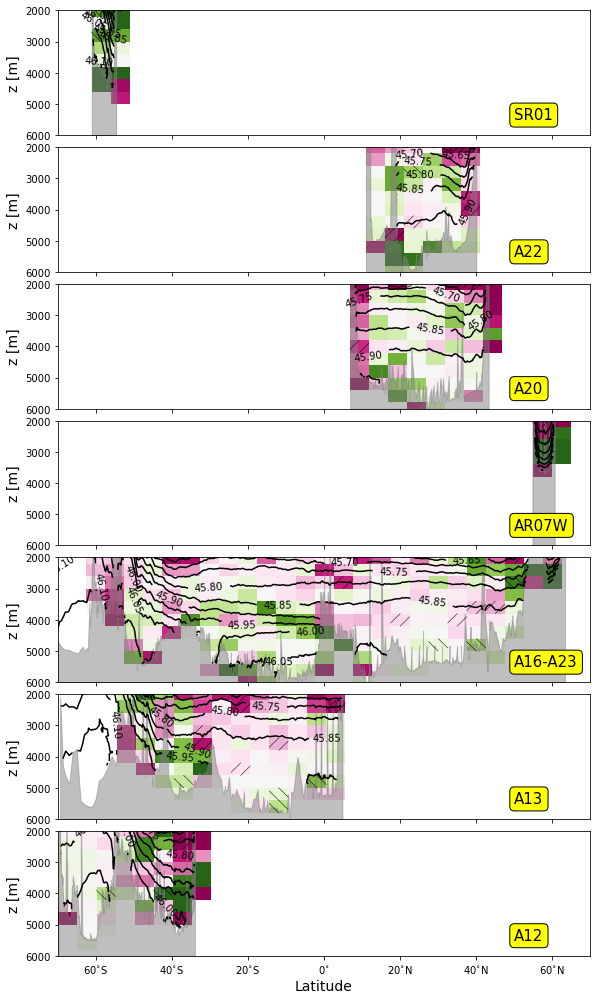

In [12]:
fig, ax = plt.subplots(nrows=len(lon_sec), ncols=1, figsize=(140/100*6, len(lon_sec)*2), sharex=True)
for i in range(len(lon_sec)):
    acquisition = lon_sec[i]
    Data = xr.open_dataset(datafilepath + acquisition.lower() + ".nc")
    Data_trend = xr.open_dataset(datafilepath + acquisition.lower() + "_trend.nc")
    Data_trend_sig4 = xr.open_dataset(datafilepath+ acquisition.lower() + "_sig4_trend.nc")
    
    plot_N2_trend_z(Data_trend, ax[i], np.diff(Data_trend.LL_st)[0], np.diff(Data_trend.z_N2)[0], vrange=param_plot['vlim1'], yrange=[param_plot['z1_lw'], param_plot['z1_up']])
    cs = ax[i].contour(Data.LL, Data.z_N2, np.nanmean(Data.Sig4_N2,axis=0).T, levels=np.arange(param_plot['sig1_up'], param_plot['sig1_lw'], .05),colors='k',linewidth='.5')
    ax[i].clabel(cs, cs.levels, fmt ='%1.2f',  inline=True, fontsize=10)        
#     ax[i].set_title(acquisition, fontsize=15)
    ax[i].text(50, 5500, acquisition, fontsize=15, bbox=dict(boxstyle='round', facecolor='yellow'))
    ax[i].set_ylabel('z [m]', fontsize=14)
    ax[i].set_xlim([-70, 70])
    ax[i].set_xticks(np.arange(-60, 60+1, 20))
    if i == len(lon_sec)-1:
        ax[i].set_xticklabels(['60$^{\circ}$S','40$^{\circ}$S','20$^{\circ}$S','0$^{\circ}$',
                            '20$^{\circ}$N','40$^{\circ}$N','60$^{\circ}$N'])
        ax[i].set_xlabel('Latitude', fontsize=14)
        
    if lon_sec[i].startswith('S'):
        loc_ll, dep_ll = loc_dep_sec(lon_sec[i], method_sec, datafilepath_sec+'southern/')
    else:
        loc_ll, dep_ll = loc_dep_sec(lon_sec[i], method_sec, datafilepath_sec+'atlantic/')
    
    ax[i].fill_between(loc_ll, dep_ll, param_plot['z1_lw'], color='.5', alpha=.5)
    

plt.tight_layout(h_pad=.2)
plt.savefig(outfilepath+ 'Atlantic_meridional_N2trend.jpeg', dpi=300)
plt.savefig(outfilepath+ 'Atlantic_meridional_N2trend.eps')

### 2. latitudinal sections

In [13]:
# latitudinal sections
lat_sec = ['75N', 'AR07E', 'A02', 'A05', 'A10', 'SR04']
method_sec = 0

/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/4202119098.py:7: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  ax.pcolormesh(np.hstack([data_N2_trend.LL_st.data,data_N2_trend.LL_st.data[-1]+dl]),
/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/2505692806.py:17: RuntimeWarning: Mean of empty slice
  cs = ax[i].contour(Data.LL, Data.z_N2, np.nanmean(Data.Sig4_N2,axis=0).T, levels=np.arange(param_plot['sig1_up'], param_plot['sig1_lw'], .05),colors='k',linewidth='.5')
/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/2505692806.py:17: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cs = ax[i].contour(Data.LL, Data.z_N2, np.nanmean(Data.Sig4_N2,axis=0).T, levels=np.arange(param_plot['sig1_up'], param_plot['sig1_lw'], .05),colors='k',linewidth='.

---------- 75N ----------


/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/4202119098.py:7: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  ax.pcolormesh(np.hstack([data_N2_trend.LL_st.data,data_N2_trend.LL_st.data[-1]+dl]),
/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/2505692806.py:17: RuntimeWarning: Mean of empty slice
  cs = ax[i].contour(Data.LL, Data.z_N2, np.nanmean(Data.Sig4_N2,axis=0).T, levels=np.arange(param_plot['sig1_up'], param_plot['sig1_lw'], .05),colors='k',linewidth='.5')
/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/2505692806.py:17: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cs = ax[i].contour(Data.LL, Data.z_N2, np.nanmean(Data.Sig4_N2,axis=0).T, levels=np.arange(param_plot['sig1_up'], param_plot['sig1_lw'], .05),colors='k',linewidth='.

---------- AR07E ----------


/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/4202119098.py:7: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  ax.pcolormesh(np.hstack([data_N2_trend.LL_st.data,data_N2_trend.LL_st.data[-1]+dl]),
/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/2505692806.py:17: RuntimeWarning: Mean of empty slice
  cs = ax[i].contour(Data.LL, Data.z_N2, np.nanmean(Data.Sig4_N2,axis=0).T, levels=np.arange(param_plot['sig1_up'], param_plot['sig1_lw'], .05),colors='k',linewidth='.5')
/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/2505692806.py:17: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cs = ax[i].contour(Data.LL, Data.z_N2, np.nanmean(Data.Sig4_N2,axis=0).T, levels=np.arange(param_plot['sig1_up'], param_plot['sig1_lw'], .05),colors='k',linewidth='.

---------- A02 ----------


/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/4202119098.py:7: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  ax.pcolormesh(np.hstack([data_N2_trend.LL_st.data,data_N2_trend.LL_st.data[-1]+dl]),
/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/2505692806.py:17: RuntimeWarning: Mean of empty slice
  cs = ax[i].contour(Data.LL, Data.z_N2, np.nanmean(Data.Sig4_N2,axis=0).T, levels=np.arange(param_plot['sig1_up'], param_plot['sig1_lw'], .05),colors='k',linewidth='.5')
/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/2505692806.py:17: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cs = ax[i].contour(Data.LL, Data.z_N2, np.nanmean(Data.Sig4_N2,axis=0).T, levels=np.arange(param_plot['sig1_up'], param_plot['sig1_lw'], .05),colors='k',linewidth='.

---------- A05 ----------


/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/4202119098.py:7: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  ax.pcolormesh(np.hstack([data_N2_trend.LL_st.data,data_N2_trend.LL_st.data[-1]+dl]),
/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/2505692806.py:17: RuntimeWarning: Mean of empty slice
  cs = ax[i].contour(Data.LL, Data.z_N2, np.nanmean(Data.Sig4_N2,axis=0).T, levels=np.arange(param_plot['sig1_up'], param_plot['sig1_lw'], .05),colors='k',linewidth='.5')
/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/2505692806.py:17: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cs = ax[i].contour(Data.LL, Data.z_N2, np.nanmean(Data.Sig4_N2,axis=0).T, levels=np.arange(param_plot['sig1_up'], param_plot['sig1_lw'], .05),colors='k',linewidth='.

---------- A10 ----------


/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/4202119098.py:7: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  ax.pcolormesh(np.hstack([data_N2_trend.LL_st.data,data_N2_trend.LL_st.data[-1]+dl]),
/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/2505692806.py:17: RuntimeWarning: Mean of empty slice
  cs = ax[i].contour(Data.LL, Data.z_N2, np.nanmean(Data.Sig4_N2,axis=0).T, levels=np.arange(param_plot['sig1_up'], param_plot['sig1_lw'], .05),colors='k',linewidth='.5')
/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/2505692806.py:17: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cs = ax[i].contour(Data.LL, Data.z_N2, np.nanmean(Data.Sig4_N2,axis=0).T, levels=np.arange(param_plot['sig1_up'], param_plot['sig1_lw'], .05),colors='k',linewidth='.

---------- SR04 ----------


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

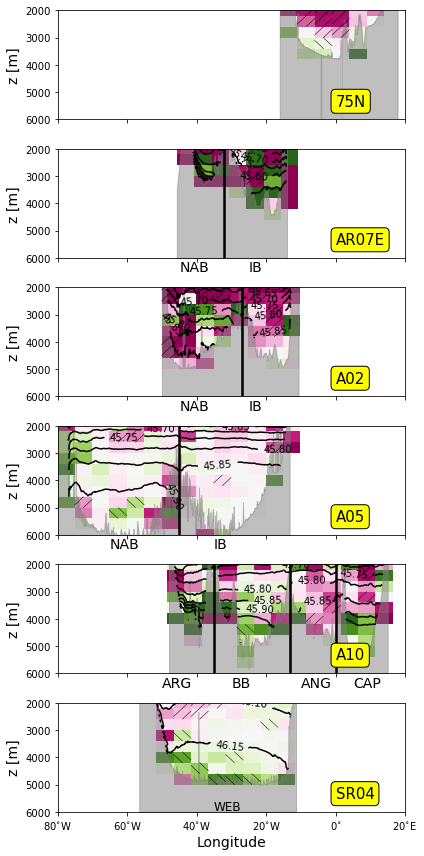

In [14]:
fig, ax = plt.subplots(nrows=len(lat_sec), ncols=1, figsize=(100/100*6, len(lat_sec)*2), sharex=True)
for i in range(len(lat_sec)):
    acquisition = lat_sec[i]
    Data = xr.open_dataset(datafilepath + acquisition.lower() + ".nc")
    Data_trend = xr.open_dataset(datafilepath + acquisition.lower() + "_trend.nc")
    Data_trend_sig4 = xr.open_dataset(datafilepath+ acquisition.lower() + "_sig4_trend.nc")
    
    ll_st = Data_trend.LL_st.data
    ll = Data.LL.data
    ll_st[ll_st>180] -= 360 
    ll[ll>180] -= 360 
    Data = Data.assign_coords(LL=ll)
    Data_trend = Data_trend.assign_coords(LL_st=ll_st)
    Data_trend_sig4 = Data_trend_sig4.assign_coords(LL_st=ll_st)    
    
    plot_N2_trend_z(Data_trend, ax[i], np.diff(Data_trend.LL_st)[0], np.diff(Data_trend.z_N2)[0], vrange=param_plot['vlim1'], yrange=[param_plot['z1_lw'], param_plot['z1_up']])
    cs = ax[i].contour(Data.LL, Data.z_N2, np.nanmean(Data.Sig4_N2,axis=0).T, levels=np.arange(param_plot['sig1_up'], param_plot['sig1_lw'], .05),colors='k',linewidth='.5')
    ax[i].clabel(cs, cs.levels, fmt ='%1.2f',  inline=True, fontsize=10)        
#     ax[i].set_title(acquisition, fontsize=15)
    ax[i].text(0, 5500, acquisition, fontsize=15, bbox=dict(boxstyle='round', facecolor='yellow'))
    ax[i].set_ylabel('z [m]', fontsize=14)
    ax[i].set_xlim([-80, 20])
    ax[i].set_xticks(np.arange(-80, 20+1, 20))
    if i == len(lat_sec)-1:
        ax[i].set_xticklabels(['80$^{\circ}$W','60$^{\circ}$W','40$^{\circ}$W','20$^{\circ}$W',
                               '0$^{\circ}$', '20$^{\circ}$E'])
        ax[i].set_xlabel('Longitude', fontsize=14)
        
    if lat_sec[i].startswith('S'):
        loc_ll, dep_ll = loc_dep_sec(lat_sec[i], method_sec, datafilepath_sec+'southern/')
        loc_ll[loc_ll>180]-=360
    else:
        loc_ll, dep_ll = loc_dep_sec(lat_sec[i], method_sec, datafilepath_sec+'atlantic/')
        loc_ll[loc_ll>180]-=360
    ax[i].fill_between(loc_ll, dep_ll, param_plot['z1_lw'], color='.5', alpha=.5)

ax[-1].text(-35, 5950, 'WEB', fontsize=12)
ax[-2].plot([-35, -35], [2000, 6000], 'k', lw=2.5)
ax[-2].plot([-13, -13], [2000, 6000], 'k', lw=2.5)
ax[-2].plot([0, 0], [2000, 6000], 'k', lw=2.5)
ax[-2].text(-50, 6500, 'ARG', fontsize=14)
ax[-2].text(-30, 6500, 'BB', fontsize=14)
ax[-2].text(-10, 6500, 'ANG', fontsize=14)
ax[-2].text(5, 6500, 'CAP', fontsize=14)
ax[-3].plot([-45, -45], [2000, 6000], 'k', lw=2.5)
ax[-3].text(-65, 6500, 'NAB', fontsize=14)
ax[-3].text(-35, 6500, 'IB', fontsize=14)
ax[2].plot([-27, -27], [2000, 6000], 'k', lw=2.5)
ax[2].text(-45, 6500, 'NAB', fontsize=14)
ax[2].text(-25, 6500, 'IB', fontsize=14)
ax[1].plot([-32, -32], [2000, 6000], 'k', lw=2.5)
ax[1].text(-45, 6500, 'NAB', fontsize=14)
ax[1].text(-25, 6500, 'IB', fontsize=14)

plt.tight_layout()
plt.savefig(outfilepath+ 'Atlantic_zonal_N2trend.jpeg', dpi=300)
plt.savefig(outfilepath+ 'Atlantic_zonal_N2trend.eps')

/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/4202119098.py:31: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  ax.pcolormesh(np.hstack([data_N2_trend.LL_st.data,data_N2_trend.LL_st.data[-1]+dl]),
/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/4202119098.py:31: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  ax.pcolormesh(np.hstack([data_N2_trend.LL_st.data,data_N2_trend.LL_st.data[-1]+dl]),
/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/4202119098.py:31: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two min

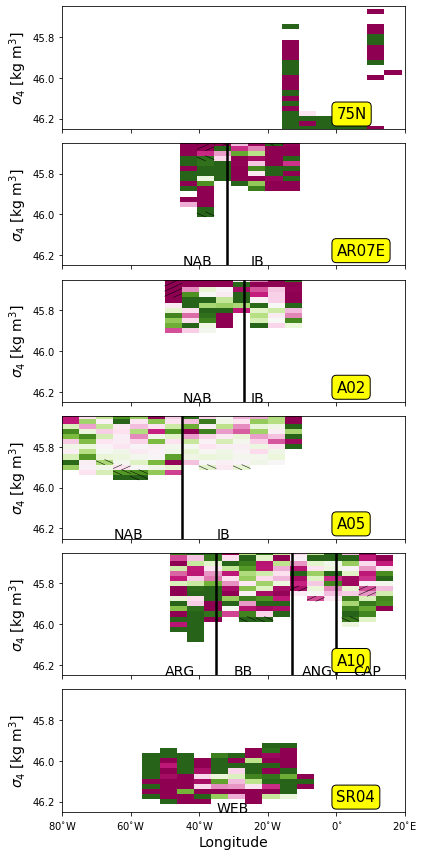

In [15]:
fig, ax = plt.subplots(nrows=len(lat_sec), ncols=1, figsize=(100/100*6, len(lat_sec)*2), sharex=True)
for i in range(len(lat_sec)):
    acquisition = lat_sec[i]
    Data_trend = xr.open_dataset(datafilepath + acquisition.lower() + "_trend.nc")
    Data_trend_sig4 = xr.open_dataset(datafilepath+ acquisition.lower() + "_sig4_trend.nc")

    ll_st = Data_trend.LL_st.data
    ll = Data.LL.data
    ll_st[ll_st>180] -= 360 
    ll[ll>180] -= 360 
    Data = Data.assign_coords(LL=ll)
    Data_trend = Data_trend.assign_coords(LL_st=ll_st)
    Data_trend_sig4 = Data_trend_sig4.assign_coords(LL_st=ll_st)      
    
    plot_N2_trend_sig(Data_trend_sig4, ax[i], np.diff(Data_trend_sig4.LL_st)[0], np.diff(Data_trend_sig4.z_N2)[0], vrange=param_plot['vlim1'], yrange=[param_plot['sig1_lw'], param_plot['sig1_up']])
#     ax[i].set_title(acquisition, fontsize=15)
    ax[i].text(0, 46.2, acquisition, fontsize=15, bbox=dict(boxstyle='round', facecolor='yellow'))
    ax[i].set_ylabel('$\sigma_4$ [kg m$^3$]', fontsize=14)
    ax[i].set_xlim([-80, 20])
    ax[i].set_xticks(np.arange(-80, 20+1, 20))
    if i == len(lat_sec)-1:
        ax[i].set_xticklabels(['80$^{\circ}$W','60$^{\circ}$W','40$^{\circ}$W','20$^{\circ}$W',
                               '0$^{\circ}$', '20$^{\circ}$E'])
        ax[i].set_xlabel('Longitude', fontsize=14)

ax[-1].text(-35, param_plot['sig1_lw'], 'WEB', fontsize=14)
ax[-2].plot([-35, -35], [param_plot['sig1_lw'], param_plot['sig1_up']], 'k', lw=2.5)
ax[-2].plot([-13, -13], [param_plot['sig1_lw'], param_plot['sig1_up']], 'k', lw=2.5)
ax[-2].plot([0, 0], [param_plot['sig1_lw'], param_plot['sig1_up']], 'k', lw=2.5)
ax[-2].text(-50, param_plot['sig1_lw'], 'ARG', fontsize=14)
ax[-2].text(-30, param_plot['sig1_lw'], 'BB', fontsize=14)
ax[-2].text(-10, param_plot['sig1_lw'], 'ANG', fontsize=14)
ax[-2].text(5, param_plot['sig1_lw'], 'CAP', fontsize=14)
ax[-3].plot([-45, -45], [param_plot['sig1_lw'], param_plot['sig1_up']], 'k', lw=2.5)
ax[-3].text(-65, param_plot['sig1_lw'], 'NAB', fontsize=14)
ax[-3].text(-35, param_plot['sig1_lw'], 'IB', fontsize=14)
ax[2].plot([-27, -27], [param_plot['sig1_lw'], param_plot['sig1_up']], 'k', lw=2.5)
ax[2].text(-45, param_plot['sig1_lw'], 'NAB', fontsize=14)
ax[2].text(-25, param_plot['sig1_lw'], 'IB', fontsize=14)
ax[1].plot([-32, -32], [param_plot['sig1_lw'], param_plot['sig1_up']], 'k', lw=2.5)
ax[1].text(-45, param_plot['sig1_lw'], 'NAB', fontsize=14)
ax[1].text(-25, param_plot['sig1_lw'], 'IB', fontsize=14)

plt.tight_layout()
plt.savefig(outfilepath+ 'Atlantic_zonal_N2trend_sigma.jpeg', dpi=300)
plt.savefig(outfilepath+ 'Atlantic_zonal_N2trend_sigma.eps')

## Pacific Ocean

### 1. selected longitudial sections

In [16]:
# longitudial sections
lon_sec = ['SR03', 'P14', 'P15', 'P16', 'P17E', 'P18']
method_sec = 1

/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/4202119098.py:7: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  ax.pcolormesh(np.hstack([data_N2_trend.LL_st.data,data_N2_trend.LL_st.data[-1]+dl]),
/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/4146295210.py:9: RuntimeWarning: Mean of empty slice
  cs = ax[i].contour(Data.LL, Data.z_N2, np.nanmean(Data.Sig4_N2,axis=0).T, levels=np.arange(param_plot['sig1_up'], param_plot['sig1_lw'], .05),colors='k',linewidth='.5')
/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/4146295210.py:9: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cs = ax[i].contour(Data.LL, Data.z_N2, np.nanmean(Data.Sig4_N2,axis=0).T, levels=np.arange(param_plot['sig1_up'], param_plot['sig1_lw'], .05),colors='k',linewidth='.5'

---------- SR03 ----------


/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/4202119098.py:7: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  ax.pcolormesh(np.hstack([data_N2_trend.LL_st.data,data_N2_trend.LL_st.data[-1]+dl]),
/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/4146295210.py:9: RuntimeWarning: Mean of empty slice
  cs = ax[i].contour(Data.LL, Data.z_N2, np.nanmean(Data.Sig4_N2,axis=0).T, levels=np.arange(param_plot['sig1_up'], param_plot['sig1_lw'], .05),colors='k',linewidth='.5')
/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/4146295210.py:9: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cs = ax[i].contour(Data.LL, Data.z_N2, np.nanmean(Data.Sig4_N2,axis=0).T, levels=np.arange(param_plot['sig1_up'], param_plot['sig1_lw'], .05),colors='k',linewidth='.5'

---------- P14 ----------


/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/4202119098.py:7: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  ax.pcolormesh(np.hstack([data_N2_trend.LL_st.data,data_N2_trend.LL_st.data[-1]+dl]),
/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/4146295210.py:9: RuntimeWarning: Mean of empty slice
  cs = ax[i].contour(Data.LL, Data.z_N2, np.nanmean(Data.Sig4_N2,axis=0).T, levels=np.arange(param_plot['sig1_up'], param_plot['sig1_lw'], .05),colors='k',linewidth='.5')
/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/4146295210.py:9: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cs = ax[i].contour(Data.LL, Data.z_N2, np.nanmean(Data.Sig4_N2,axis=0).T, levels=np.arange(param_plot['sig1_up'], param_plot['sig1_lw'], .05),colors='k',linewidth='.5'

---------- P15 ----------


/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/4202119098.py:7: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  ax.pcolormesh(np.hstack([data_N2_trend.LL_st.data,data_N2_trend.LL_st.data[-1]+dl]),
/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/4146295210.py:9: RuntimeWarning: Mean of empty slice
  cs = ax[i].contour(Data.LL, Data.z_N2, np.nanmean(Data.Sig4_N2,axis=0).T, levels=np.arange(param_plot['sig1_up'], param_plot['sig1_lw'], .05),colors='k',linewidth='.5')
/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/4146295210.py:9: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cs = ax[i].contour(Data.LL, Data.z_N2, np.nanmean(Data.Sig4_N2,axis=0).T, levels=np.arange(param_plot['sig1_up'], param_plot['sig1_lw'], .05),colors='k',linewidth='.5'

---------- P16 ----------


/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/4202119098.py:7: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  ax.pcolormesh(np.hstack([data_N2_trend.LL_st.data,data_N2_trend.LL_st.data[-1]+dl]),
/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/4146295210.py:9: RuntimeWarning: Mean of empty slice
  cs = ax[i].contour(Data.LL, Data.z_N2, np.nanmean(Data.Sig4_N2,axis=0).T, levels=np.arange(param_plot['sig1_up'], param_plot['sig1_lw'], .05),colors='k',linewidth='.5')
/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/4146295210.py:9: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cs = ax[i].contour(Data.LL, Data.z_N2, np.nanmean(Data.Sig4_N2,axis=0).T, levels=np.arange(param_plot['sig1_up'], param_plot['sig1_lw'], .05),colors='k',linewidth='.5'

---------- P17E ----------


/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/4146295210.py:9: RuntimeWarning: Mean of empty slice
  cs = ax[i].contour(Data.LL, Data.z_N2, np.nanmean(Data.Sig4_N2,axis=0).T, levels=np.arange(param_plot['sig1_up'], param_plot['sig1_lw'], .05),colors='k',linewidth='.5')
/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/4146295210.py:9: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cs = ax[i].contour(Data.LL, Data.z_N2, np.nanmean(Data.Sig4_N2,axis=0).T, levels=np.arange(param_plot['sig1_up'], param_plot['sig1_lw'], .05),colors='k',linewidth='.5')
/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/4146295210.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i].set_yticklabels(['', '', '', '',''])


---------- P18 ----------


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

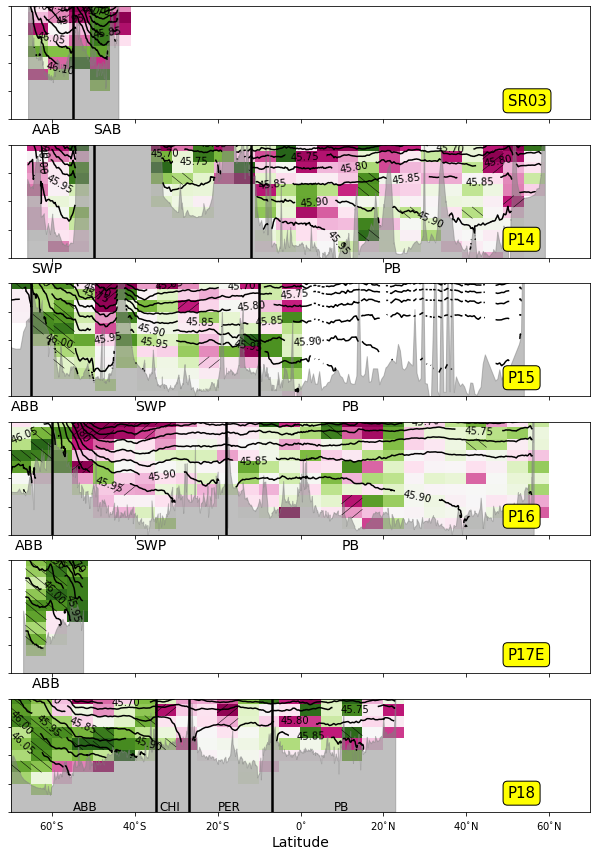

In [17]:
fig, ax = plt.subplots(nrows=len(lon_sec), ncols=1, figsize=(140/100*6, len(lon_sec)*2), sharex=True)
for i in range(len(lon_sec)):
    acquisition = lon_sec[i]
    Data = xr.open_dataset(datafilepath + acquisition.lower() + ".nc")
    Data_trend = xr.open_dataset(datafilepath + acquisition.lower() + "_trend.nc")
    Data_trend_sig4 = xr.open_dataset(datafilepath+ acquisition.lower() + "_sig4_trend.nc")
    
    plot_N2_trend_z(Data_trend, ax[i], np.diff(Data_trend.LL_st)[0], np.diff(Data_trend.z_N2)[0], vrange=param_plot['vlim1'], yrange=[param_plot['z1_lw'], param_plot['z1_up']])
    cs = ax[i].contour(Data.LL, Data.z_N2, np.nanmean(Data.Sig4_N2,axis=0).T, levels=np.arange(param_plot['sig1_up'], param_plot['sig1_lw'], .05),colors='k',linewidth='.5')
    ax[i].clabel(cs, cs.levels, fmt ='%1.2f',  inline=True, fontsize=10)        
#     ax[i].set_title(acquisition, fontsize=15)
    ax[i].text(50, 5500, acquisition, fontsize=15, bbox=dict(boxstyle='round', facecolor='yellow'))
#     ax[i].set_ylabel('z [m]', fontsize=14)
    ax[i].set_yticklabels(['', '', '', '',''])
    ax[i].set_xlim([-70, 70])
    ax[i].set_xticks(np.arange(-60, 60+1, 20))
    if i == len(lon_sec)-1:
        ax[i].set_xticklabels(['60$^{\circ}$S','40$^{\circ}$S','20$^{\circ}$S','0$^{\circ}$',
                            '20$^{\circ}$N','40$^{\circ}$N','60$^{\circ}$N'])
        ax[i].set_xlabel('Latitude', fontsize=14)
        
    if lon_sec[i].startswith('S'):
        loc_ll, dep_ll = loc_dep_sec(lon_sec[i], method_sec, datafilepath_sec+'southern/')
    else:
        loc_ll, dep_ll = loc_dep_sec(lon_sec[i], method_sec, datafilepath_sec+'pacific/')
        
    ax[i].fill_between(loc_ll, dep_ll, param_plot['z1_lw'], color='.5', alpha=.5)
    
#     fronts_, fronts_names = lat_fronts(fronts, section_loc[section_name.index(lon_sec[i])])
#     for j in range(len(fronts_)):
#         ax[i].plot([fronts_[j], fronts_[j]], [2000, 6000], c=fronts_colors[j], label=fronts_names[j])

ax[0].text(-65, 6500, 'AAB', fontsize=14)
ax[0].plot([-55, -55], [2000, 6000], 'k', lw=2.5)
ax[0].text(-50, 6500, 'SAB', fontsize=14)

ax[1].text(-65, 6500, 'SWP', fontsize=14)
ax[1].plot([-50, -50], [2000, 6000], 'k', lw=2.5)
ax[1].text(20, 6500, 'PB', fontsize=14)
ax[1].plot([-12, -12], [2000, 6000], 'k', lw=2.5)

ax[2].text(-70, 6500, 'ABB', fontsize=14)
ax[2].plot([-65, -65], [2000, 6000], 'k', lw=2.5)
ax[2].text(-40, 6500, 'SWP', fontsize=14)
ax[2].plot([-10, -10], [2000, 6000], 'k', lw=2.5)
ax[2].text(10, 6500, 'PB', fontsize=14)

ax[3].text(-69, 6500, 'ABB', fontsize=14)
ax[3].plot([-60, -60], [2000, 6000], 'k', lw=2.5)
ax[3].text(-40, 6500, 'SWP', fontsize=14)
ax[3].plot([-18, -18], [2000, 6000], 'k', lw=2.5)
ax[3].text(10, 6500, 'PB', fontsize=14)

ax[4].text(-65, 6500, 'ABB', fontsize=14)

ax[-1].text(-55, 5950, 'ABB', fontsize=12)
ax[-1].plot([-35, -35], [2000, 6000], 'k', lw=2.5)
ax[-1].text(-34, 5950, 'CHI', fontsize=12)
ax[-1].plot([-27, -27], [2000, 6000], 'k', lw=2.5)
ax[-1].text(-20, 5950, 'PER', fontsize=12)
ax[-1].plot([-7, -7], [2000, 6000], 'k', lw=2.5)
ax[-1].text(8, 5950, 'PB', fontsize=12)

plt.tight_layout()
plt.savefig(outfilepath+ 'Pacific_meridional_selected_N2trend.jpeg', dpi=300)
plt.savefig(outfilepath+ 'Pacific_meridional_selected_N2trend.eps')

/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/4202119098.py:31: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  ax.pcolormesh(np.hstack([data_N2_trend.LL_st.data,data_N2_trend.LL_st.data[-1]+dl]),
/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/4202119098.py:31: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  ax.pcolormesh(np.hstack([data_N2_trend.LL_st.data,data_N2_trend.LL_st.data[-1]+dl]),
/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/4202119098.py:31: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two min

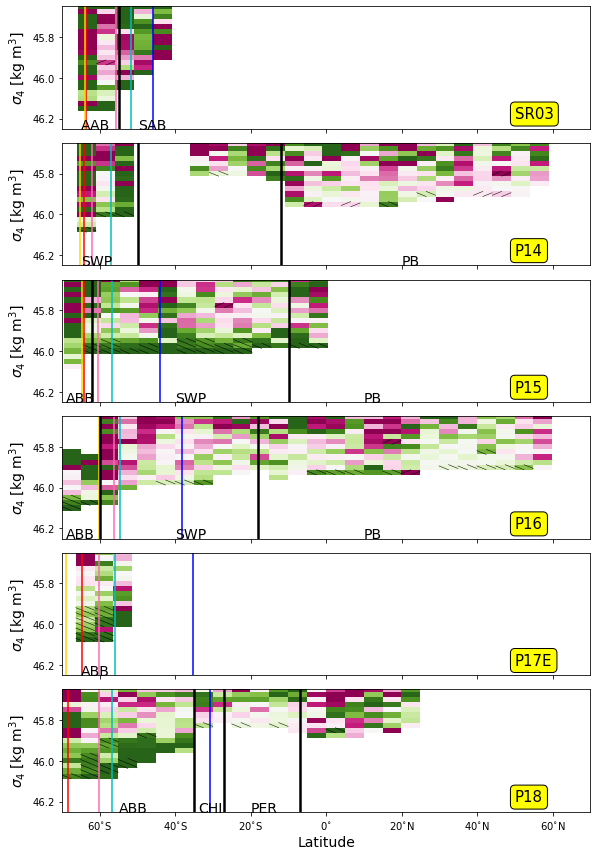

In [18]:
fig, ax = plt.subplots(nrows=len(lon_sec), ncols=1, figsize=(140/100*6, len(lon_sec)*2), sharex=True)
for i in range(len(lon_sec)):
    acquisition = lon_sec[i]
    Data_trend = xr.open_dataset(datafilepath + acquisition.lower() + "_trend.nc")
    Data_trend_sig4 = xr.open_dataset(datafilepath+ acquisition.lower() + "_sig4_trend.nc")
    
    plot_N2_trend_sig(Data_trend_sig4, ax[i], np.diff(Data_trend_sig4.LL_st)[0], np.diff(Data_trend_sig4.z_N2)[0], vrange=param_plot['vlim1'], yrange=[param_plot['sig1_lw'], param_plot['sig1_up']])
#     ax[i].set_title(acquisition, fontsize=15)
    ax[i].text(50, 46.2, acquisition, fontsize=15, bbox=dict(boxstyle='round', facecolor='yellow'))
    ax[i].set_ylabel('$\sigma_4$ [kg m$^3$]', fontsize=14)
    ax[i].set_xlim([-70, 70])
    ax[i].set_xticks(np.arange(-60, 60+1, 20))
    if i == len(lon_sec)-1:
        ax[i].set_xticklabels(['60$^{\circ}$S','40$^{\circ}$S','20$^{\circ}$S','0$^{\circ}$',
                            '20$^{\circ}$N','40$^{\circ}$N','60$^{\circ}$N'])
        ax[i].set_xlabel('Latitude', fontsize=14)
        
    fronts_, fronts_names = lat_fronts(fronts, section_loc[section_name.index(lon_sec[i])])
    for j in range(len(fronts_)):
        ax[i].plot([fronts_[j], fronts_[j]], [param_plot['sig1_lw'], param_plot['sig1_up']], c=fronts_colors[j], label=fronts_names[j])
        
ax[0].text(-65, param_plot['sig1_lw'], 'AAB', fontsize=14)
ax[0].plot([-55, -55], [param_plot['sig1_lw'], param_plot['sig1_up']], 'k', lw=2.5)
ax[0].text(-50, param_plot['sig1_lw'], 'SAB', fontsize=14)

ax[1].text(-65, param_plot['sig1_lw'], 'SWP', fontsize=14)
ax[1].plot([-50, -50], [param_plot['sig1_lw'], param_plot['sig1_up']], 'k', lw=2.5)
ax[1].text(20, param_plot['sig1_lw'], 'PB', fontsize=14)
ax[1].plot([-12, -12], [param_plot['sig1_lw'], param_plot['sig1_up']], 'k', lw=2.5)

ax[2].text(-69, param_plot['sig1_lw'], 'ABB', fontsize=14)
ax[2].plot([-62, -62], [param_plot['sig1_lw'], param_plot['sig1_up']], 'k', lw=2.5)
ax[2].text(-40, param_plot['sig1_lw'], 'SWP', fontsize=14)
ax[2].plot([-10, -10], [param_plot['sig1_lw'], param_plot['sig1_up']], 'k', lw=2.5)
ax[2].text(10, param_plot['sig1_lw'], 'PB', fontsize=14)

ax[3].text(-69, param_plot['sig1_lw'], 'ABB', fontsize=14)
ax[3].plot([-60, -60], [param_plot['sig1_lw'], param_plot['sig1_up']], 'k', lw=2.5)
ax[3].text(-40, param_plot['sig1_lw'], 'SWP', fontsize=14)
ax[3].plot([-18, -18], [param_plot['sig1_lw'], param_plot['sig1_up']], 'k', lw=2.5)
ax[3].text(10, param_plot['sig1_lw'], 'PB', fontsize=14)

ax[4].text(-65, param_plot['sig1_lw'], 'ABB', fontsize=14)

ax[-1].text(-55, param_plot['sig1_lw'], 'ABB', fontsize=14)
ax[-1].plot([-35, -35], [param_plot['sig1_lw'], param_plot['sig1_up']], 'k', lw=2.5)
ax[-1].text(-34, param_plot['sig1_lw'], 'CHI', fontsize=14)
ax[-1].plot([-27, -27], [param_plot['sig1_lw'], param_plot['sig1_up']], 'k', lw=2.5)
ax[-1].text(-20, param_plot['sig1_lw'], 'PER', fontsize=14)
ax[-1].plot([-7, -7], [param_plot['sig1_lw'], param_plot['sig1_up']], 'k', lw=2.5)

plt.tight_layout()
plt.savefig(outfilepath+ 'Pacific_meridional_selected_N2trend_sigma.jpeg', dpi=300)
plt.savefig(outfilepath+ 'Pacific_meridional_selected_N2trend_sigma.eps')

### 1*. longitudinal sections

In [19]:
lon_sec = ['SR03', 'P09', 'P10', 'P13', 'P14', 'P15', 'P16', 'P17', 'P17E', 'P18']
method_sec = 1

/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/4202119098.py:7: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  ax.pcolormesh(np.hstack([data_N2_trend.LL_st.data,data_N2_trend.LL_st.data[-1]+dl]),
/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/2301967783.py:9: RuntimeWarning: Mean of empty slice
  cs = ax[i].contour(Data.LL, Data.z_N2, np.nanmean(Data.Sig4_N2,axis=0).T, levels=np.arange(param_plot['sig1_up'], param_plot['sig1_lw'], .05),colors='k',linewidth='.5')
/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/2301967783.py:9: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cs = ax[i].contour(Data.LL, Data.z_N2, np.nanmean(Data.Sig4_N2,axis=0).T, levels=np.arange(param_plot['sig1_up'], param_plot['sig1_lw'], .05),colors='k',linewidth='.5'

---------- SR03 ----------


/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/4202119098.py:7: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  ax.pcolormesh(np.hstack([data_N2_trend.LL_st.data,data_N2_trend.LL_st.data[-1]+dl]),
/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/2301967783.py:9: RuntimeWarning: Mean of empty slice
  cs = ax[i].contour(Data.LL, Data.z_N2, np.nanmean(Data.Sig4_N2,axis=0).T, levels=np.arange(param_plot['sig1_up'], param_plot['sig1_lw'], .05),colors='k',linewidth='.5')
/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/2301967783.py:9: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cs = ax[i].contour(Data.LL, Data.z_N2, np.nanmean(Data.Sig4_N2,axis=0).T, levels=np.arange(param_plot['sig1_up'], param_plot['sig1_lw'], .05),colors='k',linewidth='.5'

---------- P09 ----------


/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/4202119098.py:7: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  ax.pcolormesh(np.hstack([data_N2_trend.LL_st.data,data_N2_trend.LL_st.data[-1]+dl]),
/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/2301967783.py:9: RuntimeWarning: Mean of empty slice
  cs = ax[i].contour(Data.LL, Data.z_N2, np.nanmean(Data.Sig4_N2,axis=0).T, levels=np.arange(param_plot['sig1_up'], param_plot['sig1_lw'], .05),colors='k',linewidth='.5')
/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/2301967783.py:9: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cs = ax[i].contour(Data.LL, Data.z_N2, np.nanmean(Data.Sig4_N2,axis=0).T, levels=np.arange(param_plot['sig1_up'], param_plot['sig1_lw'], .05),colors='k',linewidth='.5'

---------- P10 ----------


/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/4202119098.py:7: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  ax.pcolormesh(np.hstack([data_N2_trend.LL_st.data,data_N2_trend.LL_st.data[-1]+dl]),
/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/2301967783.py:9: RuntimeWarning: Mean of empty slice
  cs = ax[i].contour(Data.LL, Data.z_N2, np.nanmean(Data.Sig4_N2,axis=0).T, levels=np.arange(param_plot['sig1_up'], param_plot['sig1_lw'], .05),colors='k',linewidth='.5')
/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/2301967783.py:9: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cs = ax[i].contour(Data.LL, Data.z_N2, np.nanmean(Data.Sig4_N2,axis=0).T, levels=np.arange(param_plot['sig1_up'], param_plot['sig1_lw'], .05),colors='k',linewidth='.5'

---------- P13 ----------


/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/4202119098.py:7: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  ax.pcolormesh(np.hstack([data_N2_trend.LL_st.data,data_N2_trend.LL_st.data[-1]+dl]),
/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/2301967783.py:9: RuntimeWarning: Mean of empty slice
  cs = ax[i].contour(Data.LL, Data.z_N2, np.nanmean(Data.Sig4_N2,axis=0).T, levels=np.arange(param_plot['sig1_up'], param_plot['sig1_lw'], .05),colors='k',linewidth='.5')
/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/2301967783.py:9: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cs = ax[i].contour(Data.LL, Data.z_N2, np.nanmean(Data.Sig4_N2,axis=0).T, levels=np.arange(param_plot['sig1_up'], param_plot['sig1_lw'], .05),colors='k',linewidth='.5'

---------- P14 ----------


/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/4202119098.py:7: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  ax.pcolormesh(np.hstack([data_N2_trend.LL_st.data,data_N2_trend.LL_st.data[-1]+dl]),
/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/2301967783.py:9: RuntimeWarning: Mean of empty slice
  cs = ax[i].contour(Data.LL, Data.z_N2, np.nanmean(Data.Sig4_N2,axis=0).T, levels=np.arange(param_plot['sig1_up'], param_plot['sig1_lw'], .05),colors='k',linewidth='.5')
/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/2301967783.py:9: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cs = ax[i].contour(Data.LL, Data.z_N2, np.nanmean(Data.Sig4_N2,axis=0).T, levels=np.arange(param_plot['sig1_up'], param_plot['sig1_lw'], .05),colors='k',linewidth='.5'

---------- P15 ----------


/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/4202119098.py:7: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  ax.pcolormesh(np.hstack([data_N2_trend.LL_st.data,data_N2_trend.LL_st.data[-1]+dl]),
/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/2301967783.py:9: RuntimeWarning: Mean of empty slice
  cs = ax[i].contour(Data.LL, Data.z_N2, np.nanmean(Data.Sig4_N2,axis=0).T, levels=np.arange(param_plot['sig1_up'], param_plot['sig1_lw'], .05),colors='k',linewidth='.5')
/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/2301967783.py:9: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cs = ax[i].contour(Data.LL, Data.z_N2, np.nanmean(Data.Sig4_N2,axis=0).T, levels=np.arange(param_plot['sig1_up'], param_plot['sig1_lw'], .05),colors='k',linewidth='.5'

---------- P16 ----------


/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/4202119098.py:7: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  ax.pcolormesh(np.hstack([data_N2_trend.LL_st.data,data_N2_trend.LL_st.data[-1]+dl]),
/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/2301967783.py:9: RuntimeWarning: Mean of empty slice
  cs = ax[i].contour(Data.LL, Data.z_N2, np.nanmean(Data.Sig4_N2,axis=0).T, levels=np.arange(param_plot['sig1_up'], param_plot['sig1_lw'], .05),colors='k',linewidth='.5')
/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/2301967783.py:9: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cs = ax[i].contour(Data.LL, Data.z_N2, np.nanmean(Data.Sig4_N2,axis=0).T, levels=np.arange(param_plot['sig1_up'], param_plot['sig1_lw'], .05),colors='k',linewidth='.5'

---------- P17 ----------


/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/4202119098.py:7: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  ax.pcolormesh(np.hstack([data_N2_trend.LL_st.data,data_N2_trend.LL_st.data[-1]+dl]),
/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/2301967783.py:9: RuntimeWarning: Mean of empty slice
  cs = ax[i].contour(Data.LL, Data.z_N2, np.nanmean(Data.Sig4_N2,axis=0).T, levels=np.arange(param_plot['sig1_up'], param_plot['sig1_lw'], .05),colors='k',linewidth='.5')
/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/2301967783.py:9: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cs = ax[i].contour(Data.LL, Data.z_N2, np.nanmean(Data.Sig4_N2,axis=0).T, levels=np.arange(param_plot['sig1_up'], param_plot['sig1_lw'], .05),colors='k',linewidth='.5'

---------- P17E ----------


/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/2301967783.py:9: RuntimeWarning: Mean of empty slice
  cs = ax[i].contour(Data.LL, Data.z_N2, np.nanmean(Data.Sig4_N2,axis=0).T, levels=np.arange(param_plot['sig1_up'], param_plot['sig1_lw'], .05),colors='k',linewidth='.5')
/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/2301967783.py:9: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cs = ax[i].contour(Data.LL, Data.z_N2, np.nanmean(Data.Sig4_N2,axis=0).T, levels=np.arange(param_plot['sig1_up'], param_plot['sig1_lw'], .05),colors='k',linewidth='.5')


---------- P18 ----------


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

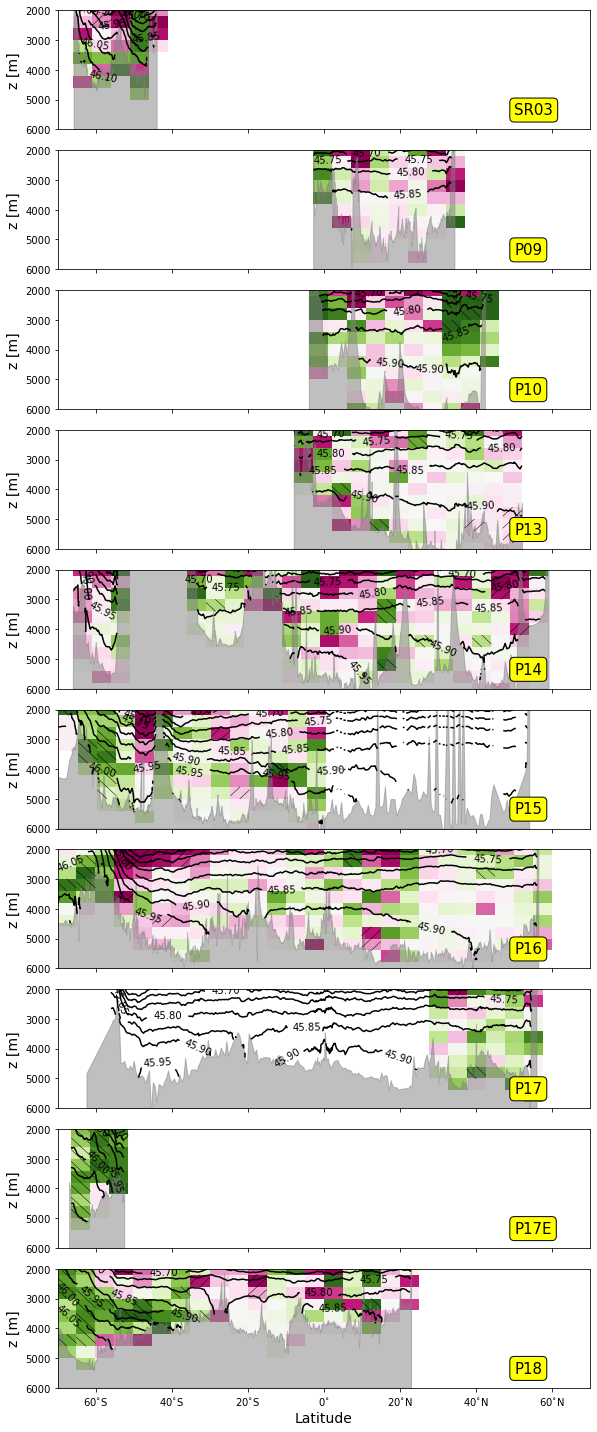

In [20]:
fig, ax = plt.subplots(nrows=len(lon_sec), ncols=1, figsize=(140/100*6, len(lon_sec)*2), sharex=True)
for i in range(len(lon_sec)):
    acquisition = lon_sec[i]
    Data = xr.open_dataset(datafilepath + acquisition.lower() + ".nc")
    Data_trend = xr.open_dataset(datafilepath + acquisition.lower() + "_trend.nc")
    Data_trend_sig4 = xr.open_dataset(datafilepath+ acquisition.lower() + "_sig4_trend.nc")
    
    plot_N2_trend_z(Data_trend, ax[i], np.diff(Data_trend.LL_st)[0], np.diff(Data_trend.z_N2)[0], vrange=param_plot['vlim1'], yrange=[param_plot['z1_lw'], param_plot['z1_up']])
    cs = ax[i].contour(Data.LL, Data.z_N2, np.nanmean(Data.Sig4_N2,axis=0).T, levels=np.arange(param_plot['sig1_up'], param_plot['sig1_lw'], .05),colors='k',linewidth='.5')
    ax[i].clabel(cs, cs.levels, fmt ='%1.2f',  inline=True, fontsize=10)        
#     ax[i].set_title(acquisition, fontsize=15)
    ax[i].text(50, 5500, acquisition, fontsize=15, bbox=dict(boxstyle='round', facecolor='yellow'))
    ax[i].set_ylabel('z [m]', fontsize=14)
    ax[i].set_xlim([-70, 70])
    ax[i].set_xticks(np.arange(-60, 60+1, 20))
    if i == len(lon_sec)-1:
        ax[i].set_xticklabels(['60$^{\circ}$S','40$^{\circ}$S','20$^{\circ}$S','0$^{\circ}$',
                            '20$^{\circ}$N','40$^{\circ}$N','60$^{\circ}$N'])
        ax[i].set_xlabel('Latitude', fontsize=14)
        
    if lon_sec[i].startswith('S'):
        loc_ll, dep_ll = loc_dep_sec(lon_sec[i], method_sec, datafilepath_sec+'southern/')
    else:
        loc_ll, dep_ll = loc_dep_sec(lon_sec[i], method_sec, datafilepath_sec+'pacific/')
        
    ax[i].fill_between(loc_ll, dep_ll, param_plot['z1_lw'], color='.5', alpha=.5)

plt.tight_layout()
plt.savefig(outfilepath+ 'Pacific_meridional_N2trend.jpeg', dpi=300)
plt.savefig(outfilepath+ 'Pacific_meridional_N2trend.eps')

### 2. latitudinal sections

In [21]:
# latitudinal sections
lat_sec = ['P01', 'P02', 'P03', 'P21', 'P06', 'S04P']
method_sec = 0

/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/4202119098.py:7: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  ax.pcolormesh(np.hstack([data_N2_trend.LL_st.data,data_N2_trend.LL_st.data[-1]+dl]),
/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/1834273467.py:9: RuntimeWarning: Mean of empty slice
  cs = ax[i].contour(Data.LL, Data.z_N2, np.nanmean(Data.Sig4_N2,axis=0).T, levels=np.arange(param_plot['sig1_up'], param_plot['sig1_lw'], .05),colors='k',linewidth='.5')
/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/1834273467.py:9: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cs = ax[i].contour(Data.LL, Data.z_N2, np.nanmean(Data.Sig4_N2,axis=0).T, levels=np.arange(param_plot['sig1_up'], param_plot['sig1_lw'], .05),colors='k',linewidth='.5'

---------- P01 ----------


/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/4202119098.py:7: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  ax.pcolormesh(np.hstack([data_N2_trend.LL_st.data,data_N2_trend.LL_st.data[-1]+dl]),
/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/1834273467.py:9: RuntimeWarning: Mean of empty slice
  cs = ax[i].contour(Data.LL, Data.z_N2, np.nanmean(Data.Sig4_N2,axis=0).T, levels=np.arange(param_plot['sig1_up'], param_plot['sig1_lw'], .05),colors='k',linewidth='.5')
/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/1834273467.py:9: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cs = ax[i].contour(Data.LL, Data.z_N2, np.nanmean(Data.Sig4_N2,axis=0).T, levels=np.arange(param_plot['sig1_up'], param_plot['sig1_lw'], .05),colors='k',linewidth='.5'

---------- P02 ----------


/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/4202119098.py:7: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  ax.pcolormesh(np.hstack([data_N2_trend.LL_st.data,data_N2_trend.LL_st.data[-1]+dl]),
/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/1834273467.py:9: RuntimeWarning: Mean of empty slice
  cs = ax[i].contour(Data.LL, Data.z_N2, np.nanmean(Data.Sig4_N2,axis=0).T, levels=np.arange(param_plot['sig1_up'], param_plot['sig1_lw'], .05),colors='k',linewidth='.5')
/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/1834273467.py:9: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cs = ax[i].contour(Data.LL, Data.z_N2, np.nanmean(Data.Sig4_N2,axis=0).T, levels=np.arange(param_plot['sig1_up'], param_plot['sig1_lw'], .05),colors='k',linewidth='.5'

---------- P03 ----------


/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/4202119098.py:7: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  ax.pcolormesh(np.hstack([data_N2_trend.LL_st.data,data_N2_trend.LL_st.data[-1]+dl]),
/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/1834273467.py:9: RuntimeWarning: Mean of empty slice
  cs = ax[i].contour(Data.LL, Data.z_N2, np.nanmean(Data.Sig4_N2,axis=0).T, levels=np.arange(param_plot['sig1_up'], param_plot['sig1_lw'], .05),colors='k',linewidth='.5')
/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/1834273467.py:9: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cs = ax[i].contour(Data.LL, Data.z_N2, np.nanmean(Data.Sig4_N2,axis=0).T, levels=np.arange(param_plot['sig1_up'], param_plot['sig1_lw'], .05),colors='k',linewidth='.5'

---------- P21 ----------


/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/4202119098.py:7: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  ax.pcolormesh(np.hstack([data_N2_trend.LL_st.data,data_N2_trend.LL_st.data[-1]+dl]),
/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/1834273467.py:9: RuntimeWarning: Mean of empty slice
  cs = ax[i].contour(Data.LL, Data.z_N2, np.nanmean(Data.Sig4_N2,axis=0).T, levels=np.arange(param_plot['sig1_up'], param_plot['sig1_lw'], .05),colors='k',linewidth='.5')
/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/1834273467.py:9: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cs = ax[i].contour(Data.LL, Data.z_N2, np.nanmean(Data.Sig4_N2,axis=0).T, levels=np.arange(param_plot['sig1_up'], param_plot['sig1_lw'], .05),colors='k',linewidth='.5'

---------- P06 ----------


/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/4202119098.py:7: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  ax.pcolormesh(np.hstack([data_N2_trend.LL_st.data,data_N2_trend.LL_st.data[-1]+dl]),
/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/1834273467.py:9: RuntimeWarning: Mean of empty slice
  cs = ax[i].contour(Data.LL, Data.z_N2, np.nanmean(Data.Sig4_N2,axis=0).T, levels=np.arange(param_plot['sig1_up'], param_plot['sig1_lw'], .05),colors='k',linewidth='.5')
/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/1834273467.py:9: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cs = ax[i].contour(Data.LL, Data.z_N2, np.nanmean(Data.Sig4_N2,axis=0).T, levels=np.arange(param_plot['sig1_up'], param_plot['sig1_lw'], .05),colors='k',linewidth='.5'

---------- S04P ----------


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

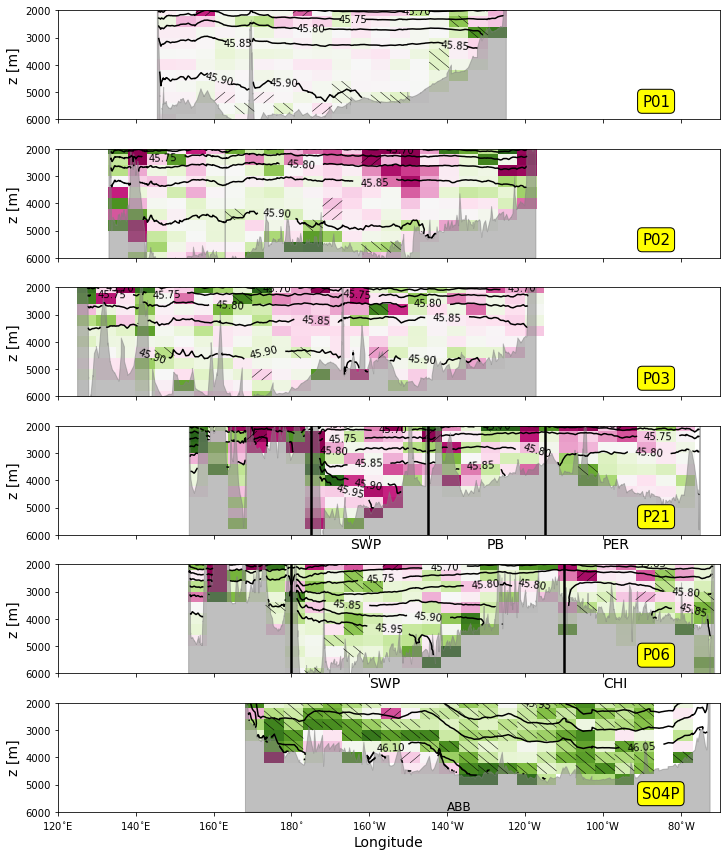

In [22]:
fig, ax = plt.subplots(nrows=len(lat_sec), ncols=1, figsize=(170/100*6, len(lat_sec)*2), sharex=True)
for i in range(len(lat_sec)):
    acquisition = lat_sec[i]
    Data = xr.open_dataset(datafilepath + acquisition.lower() + ".nc")
    Data_trend = xr.open_dataset(datafilepath + acquisition.lower() + "_trend.nc")
    Data_trend_sig4 = xr.open_dataset(datafilepath+ acquisition.lower() + "_sig4_trend.nc")
    
    plot_N2_trend_z(Data_trend, ax[i], np.diff(Data_trend.LL_st)[0], np.diff(Data_trend.z_N2)[0], vrange=param_plot['vlim1'], yrange=[param_plot['z1_lw'], param_plot['z1_up']])
    cs = ax[i].contour(Data.LL, Data.z_N2, np.nanmean(Data.Sig4_N2,axis=0).T, levels=np.arange(param_plot['sig1_up'], param_plot['sig1_lw'], .05),colors='k',linewidth='.5')
    ax[i].clabel(cs, cs.levels, fmt ='%1.2f',  inline=True, fontsize=10)        
#     ax[i].set_title(acquisition, fontsize=15)
    ax[i].text(270, 5500, acquisition, fontsize=15, bbox=dict(boxstyle='round', facecolor='yellow'))
    ax[i].set_ylabel('z [m]', fontsize=14)
    ax[i].set_xlim([120, 290])
    ax[i].set_xticks(np.arange(120, 290, 20))
    if i == len(lat_sec)-1:
        ax[i].set_xticklabels(['120$^{\circ}$E','140$^{\circ}$E','160$^{\circ}$E','180$^{\circ}$',
                               '160$^{\circ}$W', '140$^{\circ}$W', '120$^{\circ}$W', '100$^{\circ}$W', '80$^{\circ}$W'])
        ax[i].set_xlabel('Longitude', fontsize=14)       
        
    if lat_sec[i].startswith('S'):
        loc_ll, dep_ll = loc_dep_sec(lat_sec[i], method_sec, datafilepath_sec+'southern/')
#         loc_ll[loc_ll>180]-=360
    else:
        loc_ll, dep_ll = loc_dep_sec(lat_sec[i], method_sec, datafilepath_sec+'pacific/')
#         loc_ll[loc_ll>180]-=360   
    ax[i].fill_between(loc_ll, dep_ll, param_plot['z1_lw'], color='.5', alpha=.5)

ax[-1].text(220, 5950, 'ABB', fontsize=12)
ax[-2].plot([180, 180], [2000, 6000], 'k', lw=2.5)
ax[-2].plot([250, 250], [2000, 6000], 'k', lw=2.5)
ax[-2].text(200, 6500, 'SWP', fontsize=14)
ax[-2].text(260, 6500, 'CHI', fontsize=14)
ax[-3].plot([185, 185], [2000, 6000], 'k', lw=2.5)
ax[-3].plot([215, 215], [2000, 6000], 'k', lw=2.5)
ax[-3].plot([245, 245], [2000, 6000], 'k', lw=2.5)
ax[-3].text(195, 6500, 'SWP', fontsize=14)
ax[-3].text(230, 6500, 'PB', fontsize=14)
ax[-3].text(260, 6500, 'PER', fontsize=14)

plt.tight_layout()
plt.savefig(outfilepath+ 'Pacific_zonal_N2trend.jpeg', dpi=300)
plt.savefig(outfilepath+ 'Pacific_zonal_N2trend.eps')

/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/4202119098.py:31: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  ax.pcolormesh(np.hstack([data_N2_trend.LL_st.data,data_N2_trend.LL_st.data[-1]+dl]),
/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/4202119098.py:31: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  ax.pcolormesh(np.hstack([data_N2_trend.LL_st.data,data_N2_trend.LL_st.data[-1]+dl]),
/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/4202119098.py:31: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two min

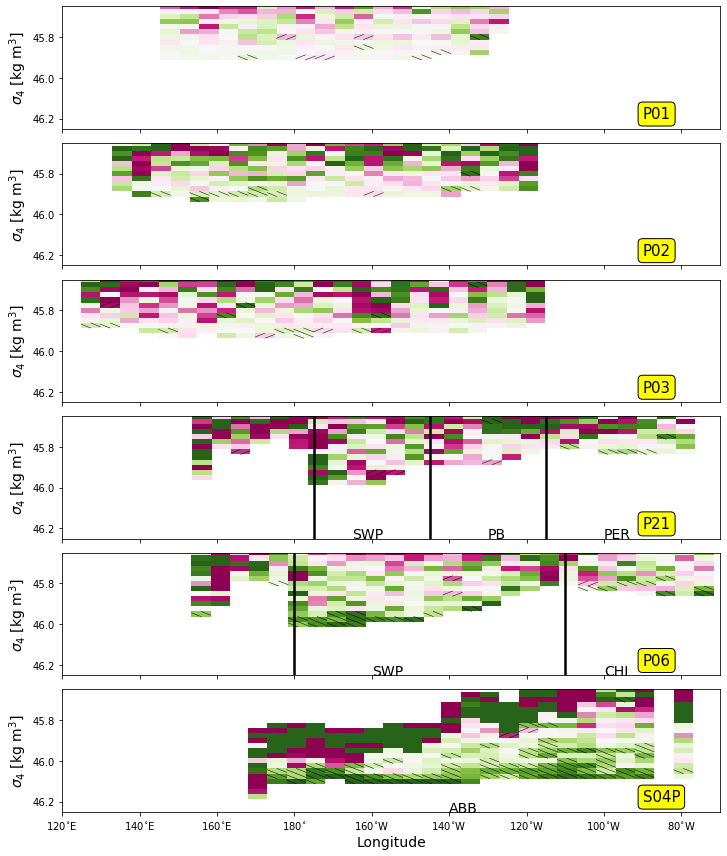

In [23]:
fig, ax = plt.subplots(nrows=len(lat_sec), ncols=1, figsize=(170/100*6, len(lat_sec)*2), sharex=True)
for i in range(len(lat_sec)):
    acquisition = lat_sec[i]
    Data_trend = xr.open_dataset(datafilepath + acquisition.lower() + "_trend.nc")
    Data_trend_sig4 = xr.open_dataset(datafilepath+ acquisition.lower() + "_sig4_trend.nc")
    
    plot_N2_trend_sig(Data_trend_sig4, ax[i], np.diff(Data_trend_sig4.LL_st)[0], np.diff(Data_trend_sig4.z_N2)[0], vrange=param_plot['vlim1'], yrange=[param_plot['sig1_lw'], param_plot['sig1_up']])
#     ax[i].set_title(acquisition, fontsize=15)
    ax[i].text(270, 46.2, acquisition, fontsize=15, bbox=dict(boxstyle='round', facecolor='yellow'))
    ax[i].set_ylabel('$\sigma_4$ [kg m$^3$]', fontsize=14)
    ax[i].set_xlim([120, 290])
    ax[i].set_xticks(np.arange(120, 290, 20))
    if i == len(lat_sec)-1:
        ax[i].set_xticklabels(['120$^{\circ}$E','140$^{\circ}$E','160$^{\circ}$E','180$^{\circ}$',
                               '160$^{\circ}$W', '140$^{\circ}$W', '120$^{\circ}$W', '100$^{\circ}$W', '80$^{\circ}$W'])
        ax[i].set_xlabel('Longitude', fontsize=14)

ax[-1].text(220, param_plot['sig1_lw'], 'ABB', fontsize=14)
ax[-2].plot([180, 180], [param_plot['sig1_lw'], param_plot['sig1_up']], 'k', lw=2.5)
ax[-2].plot([250, 250], [param_plot['sig1_lw'], param_plot['sig1_up']], 'k', lw=2.5)
ax[-2].text(200, param_plot['sig1_lw'], 'SWP', fontsize=14)
ax[-2].text(260, param_plot['sig1_lw'], 'CHI', fontsize=14)
ax[-3].plot([185, 185], [param_plot['sig1_lw'], param_plot['sig1_up']], 'k', lw=2.5)
ax[-3].plot([215, 215], [param_plot['sig1_lw'], param_plot['sig1_up']], 'k', lw=2.5)
ax[-3].plot([245, 245], [param_plot['sig1_lw'], param_plot['sig1_up']], 'k', lw=2.5)
ax[-3].text(195, param_plot['sig1_lw'], 'SWP', fontsize=14)
ax[-3].text(230, param_plot['sig1_lw'], 'PB', fontsize=14)
ax[-3].text(260, param_plot['sig1_lw'], 'PER', fontsize=14)

plt.tight_layout()
plt.savefig(outfilepath+ 'Pacific_zonal_N2trend_sigma.jpeg', dpi=300)
plt.savefig(outfilepath+ 'Pacific_zonal_N2trend_sigma.eps')

## Indian Ocean

### 1. selected longitudial sections

In [24]:
# longitudial sections
lon_sec = ['I06S', 'I08S-I09N', 'I09S']
method_sec = 1

/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/4202119098.py:7: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  ax.pcolormesh(np.hstack([data_N2_trend.LL_st.data,data_N2_trend.LL_st.data[-1]+dl]),
/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/3771948990.py:9: RuntimeWarning: Mean of empty slice
  cs = ax[i].contour(Data.LL, Data.z_N2, np.nanmean(Data.Sig4_N2,axis=0).T, levels=np.arange(param_plot['sig1_up'], param_plot['sig1_lw'], .05),colors='k',linewidth='.5')
/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/3771948990.py:9: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cs = ax[i].contour(Data.LL, Data.z_N2, np.nanmean(Data.Sig4_N2,axis=0).T, levels=np.arange(param_plot['sig1_up'], param_plot['sig1_lw'], .05),colors='k',linewidth='.5'

---------- I06S ----------


/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/4202119098.py:7: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  ax.pcolormesh(np.hstack([data_N2_trend.LL_st.data,data_N2_trend.LL_st.data[-1]+dl]),
/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/3771948990.py:9: RuntimeWarning: Mean of empty slice
  cs = ax[i].contour(Data.LL, Data.z_N2, np.nanmean(Data.Sig4_N2,axis=0).T, levels=np.arange(param_plot['sig1_up'], param_plot['sig1_lw'], .05),colors='k',linewidth='.5')
/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/3771948990.py:9: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cs = ax[i].contour(Data.LL, Data.z_N2, np.nanmean(Data.Sig4_N2,axis=0).T, levels=np.arange(param_plot['sig1_up'], param_plot['sig1_lw'], .05),colors='k',linewidth='.5'

---------- I08S-I09N ----------


/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/4202119098.py:7: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  ax.pcolormesh(np.hstack([data_N2_trend.LL_st.data,data_N2_trend.LL_st.data[-1]+dl]),
/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/3771948990.py:9: RuntimeWarning: Mean of empty slice
  cs = ax[i].contour(Data.LL, Data.z_N2, np.nanmean(Data.Sig4_N2,axis=0).T, levels=np.arange(param_plot['sig1_up'], param_plot['sig1_lw'], .05),colors='k',linewidth='.5')
/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/3771948990.py:9: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cs = ax[i].contour(Data.LL, Data.z_N2, np.nanmean(Data.Sig4_N2,axis=0).T, levels=np.arange(param_plot['sig1_up'], param_plot['sig1_lw'], .05),colors='k',linewidth='.5'

---------- I09S ----------


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


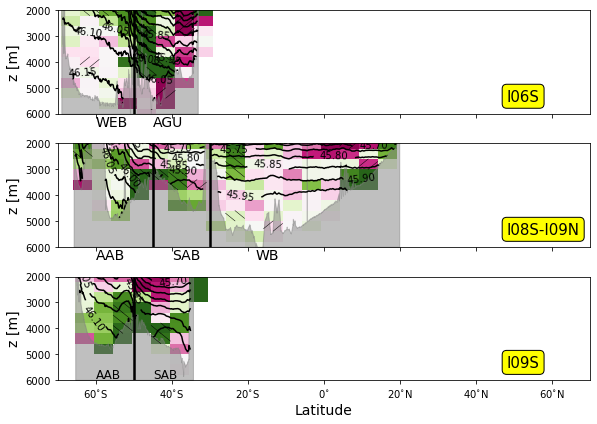

In [25]:
fig, ax = plt.subplots(nrows=len(lon_sec), ncols=1, figsize=(140/100*6, len(lon_sec)*2), sharex=True)
for i in range(len(lon_sec)):
    acquisition = lon_sec[i]
    Data = xr.open_dataset(datafilepath + acquisition.lower() + ".nc")
    Data_trend = xr.open_dataset(datafilepath + acquisition.lower() + "_trend.nc")
    Data_trend_sig4 = xr.open_dataset(datafilepath+ acquisition.lower() + "_sig4_trend.nc")
    
    plot_N2_trend_z(Data_trend, ax[i], np.diff(Data_trend.LL_st)[0], np.diff(Data_trend.z_N2)[0], vrange=param_plot['vlim1'], yrange=[param_plot['z1_lw'], param_plot['z1_up']])
    cs = ax[i].contour(Data.LL, Data.z_N2, np.nanmean(Data.Sig4_N2,axis=0).T, levels=np.arange(param_plot['sig1_up'], param_plot['sig1_lw'], .05),colors='k',linewidth='.5')
    ax[i].clabel(cs, cs.levels, fmt ='%1.2f',  inline=True, fontsize=10)        
#     ax[i].set_title(acquisition, fontsize=15)
    ax[i].text(48, 5500, acquisition, fontsize=15, bbox=dict(boxstyle='round', facecolor='yellow'))
    ax[i].set_ylabel('z [m]', fontsize=14)
    ax[i].set_xlim([-70, 70])
    ax[i].set_xticks(np.arange(-60, 60+1, 20))
    if i == len(lon_sec)-1:
        ax[i].set_xticklabels(['60$^{\circ}$S','40$^{\circ}$S','20$^{\circ}$S','0$^{\circ}$',
                            '20$^{\circ}$N','40$^{\circ}$N','60$^{\circ}$N'])
        ax[i].set_xlabel('Latitude', fontsize=14)
    if lon_sec[i].startswith('S'):
        loc_ll, dep_ll = loc_dep_sec(lon_sec[i], method_sec, datafilepath_sec+'southern/')
    else:
        loc_ll, dep_ll = loc_dep_sec(lon_sec[i], method_sec, datafilepath_sec+'indian/')
    ax[i].fill_between(loc_ll, dep_ll, param_plot['z1_lw'], color='.5', alpha=.5)

#     fronts_, fronts_names = lat_fronts(fronts, section_loc[section_name.index(lon_sec[i])])
#     for j in range(len(fronts_)):
#         ax[i].plot([fronts_[j], fronts_[j]], [2000, 6000], c=fronts_colors[j], label=fronts_names[j])

ax[0].text(-60, 6500, 'WEB', fontsize=14)
ax[0].plot([-50, -50], [2000, 6000], 'k', lw=2.5)
ax[0].text(-45, 6500, 'AGU', fontsize=14)

ax[1].text(-60, 6500, 'AAB', fontsize=14)
ax[1].plot([-45, -45], [2000, 6000], 'k', lw=2.5)
ax[1].text(-40, 6500, 'SAB', fontsize=14)
ax[1].plot([-30, -30], [2000, 6000], 'k', lw=2.5)
ax[1].text(-18, 6500, 'WB', fontsize=14)

ax[-1].text(-60, 5950, 'AAB', fontsize=12)
ax[-1].plot([-50, -50], [2000, 6000], 'k', lw=2.5)
ax[-1].text(-45, 5950, 'SAB', fontsize=12)

plt.tight_layout()
plt.savefig(outfilepath+ 'Indian_meridional_selected_N2trend.jpeg', dpi=300)
plt.savefig(outfilepath+ 'Indian_meridional_selected_N2trend.eps')

/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/4202119098.py:31: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  ax.pcolormesh(np.hstack([data_N2_trend.LL_st.data,data_N2_trend.LL_st.data[-1]+dl]),
/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/4202119098.py:31: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  ax.pcolormesh(np.hstack([data_N2_trend.LL_st.data,data_N2_trend.LL_st.data[-1]+dl]),
/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/4202119098.py:31: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two min

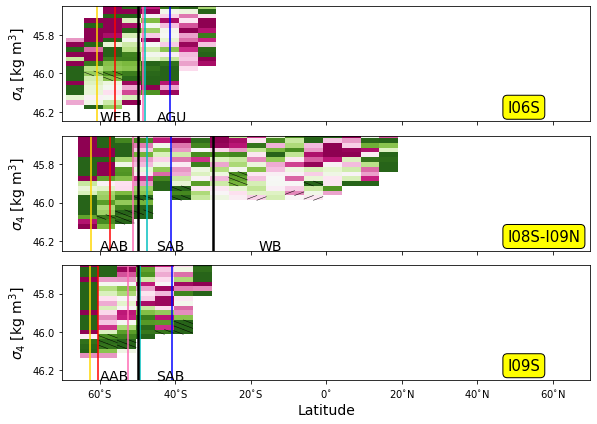

In [26]:
fig, ax = plt.subplots(nrows=len(lon_sec), ncols=1, figsize=(140/100*6, len(lon_sec)*2), sharex=True)
for i in range(len(lon_sec)):
    acquisition = lon_sec[i]
    Data_trend = xr.open_dataset(datafilepath + acquisition.lower() + "_trend.nc")
    Data_trend_sig4 = xr.open_dataset(datafilepath+ acquisition.lower() + "_sig4_trend.nc")
    
    plot_N2_trend_sig(Data_trend_sig4, ax[i], np.diff(Data_trend_sig4.LL_st)[0], np.diff(Data_trend_sig4.z_N2)[0], vrange=param_plot['vlim1'], yrange=[param_plot['sig1_lw'], param_plot['sig1_up']])
#     ax[i].set_title(acquisition, fontsize=15)
    ax[i].text(48, 46.2, acquisition, fontsize=15, bbox=dict(boxstyle='round', facecolor='yellow'))
    ax[i].set_ylabel('$\sigma_4$ [kg m$^3$]', fontsize=14)
    ax[i].set_xlim([-70, 70])
    ax[i].set_xticks(np.arange(-60, 60+1, 20))
    if i == len(lon_sec)-1:
        ax[i].set_xticklabels(['60$^{\circ}$S','40$^{\circ}$S','20$^{\circ}$S','0$^{\circ}$',
                            '20$^{\circ}$N','40$^{\circ}$N','60$^{\circ}$N'])
        ax[i].set_xlabel('Latitude', fontsize=14)

    fronts_, fronts_names = lat_fronts(fronts, section_loc[section_name.index(lon_sec[i])])
    for j in range(len(fronts_)):
        ax[i].plot([fronts_[j], fronts_[j]], [param_plot['sig1_lw'], param_plot['sig1_up']], c=fronts_colors[j], label=fronts_names[j])

ax[0].text(-60, param_plot['sig1_lw'], 'WEB', fontsize=14)
ax[0].plot([-50, -50], [param_plot['sig1_lw'], param_plot['sig1_up']], 'k', lw=2.5)
ax[0].text(-45, param_plot['sig1_lw'], 'AGU', fontsize=14)

ax[1].text(-60, param_plot['sig1_lw'], 'AAB', fontsize=14)
ax[1].plot([-50, -50], [param_plot['sig1_lw'], param_plot['sig1_up']], 'k', lw=2.5)
ax[1].text(-45, param_plot['sig1_lw'], 'SAB', fontsize=14)
ax[1].plot([-30, -30], [param_plot['sig1_lw'], param_plot['sig1_up']], 'k', lw=2.5)
ax[1].text(-18, param_plot['sig1_lw'], 'WB', fontsize=14)

ax[-1].text(-60, param_plot['sig1_lw'], 'AAB', fontsize=14)
ax[-1].plot([-50, -50], [param_plot['sig1_lw'], param_plot['sig1_up']], 'k', lw=2.5)
ax[-1].text(-45, param_plot['sig1_lw'], 'SAB', fontsize=14)

plt.tight_layout()
plt.savefig(outfilepath+ 'Indian_meridional_selected_N2trend_sigma.jpeg', dpi=300)
plt.savefig(outfilepath+ 'Indian_meridional_selected_N2trend_sigma.eps')

### 1*. longitudinal sections

In [27]:
lon_sec = ['I06S', 'I07', 'I08N', 'I08S-I09N', 'IR06', 'I10', 'IR06E', 'I09S']
method_sec = 1


/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/4202119098.py:7: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  ax.pcolormesh(np.hstack([data_N2_trend.LL_st.data,data_N2_trend.LL_st.data[-1]+dl]),
/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/4010952544.py:9: RuntimeWarning: Mean of empty slice
  cs = ax[i].contour(Data.LL, Data.z_N2, np.nanmean(Data.Sig4_N2,axis=0).T, levels=np.arange(param_plot['sig1_up'], param_plot['sig1_lw'], .05),colors='k',linewidth='.5')
/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/4010952544.py:9: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cs = ax[i].contour(Data.LL, Data.z_N2, np.nanmean(Data.Sig4_N2,axis=0).T, levels=np.arange(param_plot['sig1_up'], param_plot['sig1_lw'], .05),colors='k',linewidth='.5'

---------- I06S ----------


/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/4202119098.py:7: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  ax.pcolormesh(np.hstack([data_N2_trend.LL_st.data,data_N2_trend.LL_st.data[-1]+dl]),
/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/4010952544.py:9: RuntimeWarning: Mean of empty slice
  cs = ax[i].contour(Data.LL, Data.z_N2, np.nanmean(Data.Sig4_N2,axis=0).T, levels=np.arange(param_plot['sig1_up'], param_plot['sig1_lw'], .05),colors='k',linewidth='.5')
/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/4010952544.py:9: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cs = ax[i].contour(Data.LL, Data.z_N2, np.nanmean(Data.Sig4_N2,axis=0).T, levels=np.arange(param_plot['sig1_up'], param_plot['sig1_lw'], .05),colors='k',linewidth='.5'

---------- I07 ----------


/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/4202119098.py:7: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  ax.pcolormesh(np.hstack([data_N2_trend.LL_st.data,data_N2_trend.LL_st.data[-1]+dl]),
/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/4010952544.py:9: RuntimeWarning: Mean of empty slice
  cs = ax[i].contour(Data.LL, Data.z_N2, np.nanmean(Data.Sig4_N2,axis=0).T, levels=np.arange(param_plot['sig1_up'], param_plot['sig1_lw'], .05),colors='k',linewidth='.5')
/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/4010952544.py:9: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cs = ax[i].contour(Data.LL, Data.z_N2, np.nanmean(Data.Sig4_N2,axis=0).T, levels=np.arange(param_plot['sig1_up'], param_plot['sig1_lw'], .05),colors='k',linewidth='.5'

---------- I08N ----------


/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/4202119098.py:7: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  ax.pcolormesh(np.hstack([data_N2_trend.LL_st.data,data_N2_trend.LL_st.data[-1]+dl]),
/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/4010952544.py:9: RuntimeWarning: Mean of empty slice
  cs = ax[i].contour(Data.LL, Data.z_N2, np.nanmean(Data.Sig4_N2,axis=0).T, levels=np.arange(param_plot['sig1_up'], param_plot['sig1_lw'], .05),colors='k',linewidth='.5')
/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/4010952544.py:9: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cs = ax[i].contour(Data.LL, Data.z_N2, np.nanmean(Data.Sig4_N2,axis=0).T, levels=np.arange(param_plot['sig1_up'], param_plot['sig1_lw'], .05),colors='k',linewidth='.5'

---------- I08S-I09N ----------


/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/4202119098.py:7: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  ax.pcolormesh(np.hstack([data_N2_trend.LL_st.data,data_N2_trend.LL_st.data[-1]+dl]),
/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/4010952544.py:9: RuntimeWarning: Mean of empty slice
  cs = ax[i].contour(Data.LL, Data.z_N2, np.nanmean(Data.Sig4_N2,axis=0).T, levels=np.arange(param_plot['sig1_up'], param_plot['sig1_lw'], .05),colors='k',linewidth='.5')
/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/4010952544.py:9: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cs = ax[i].contour(Data.LL, Data.z_N2, np.nanmean(Data.Sig4_N2,axis=0).T, levels=np.arange(param_plot['sig1_up'], param_plot['sig1_lw'], .05),colors='k',linewidth='.5'

---------- IR06 ----------
---------- I10 ----------


/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/4202119098.py:7: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  ax.pcolormesh(np.hstack([data_N2_trend.LL_st.data,data_N2_trend.LL_st.data[-1]+dl]),
/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/4010952544.py:9: RuntimeWarning: Mean of empty slice
  cs = ax[i].contour(Data.LL, Data.z_N2, np.nanmean(Data.Sig4_N2,axis=0).T, levels=np.arange(param_plot['sig1_up'], param_plot['sig1_lw'], .05),colors='k',linewidth='.5')
/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/4010952544.py:9: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cs = ax[i].contour(Data.LL, Data.z_N2, np.nanmean(Data.Sig4_N2,axis=0).T, levels=np.arange(param_plot['sig1_up'], param_plot['sig1_lw'], .05),colors='k',linewidth='.5'

---------- IR06E ----------
---------- I09S ----------


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

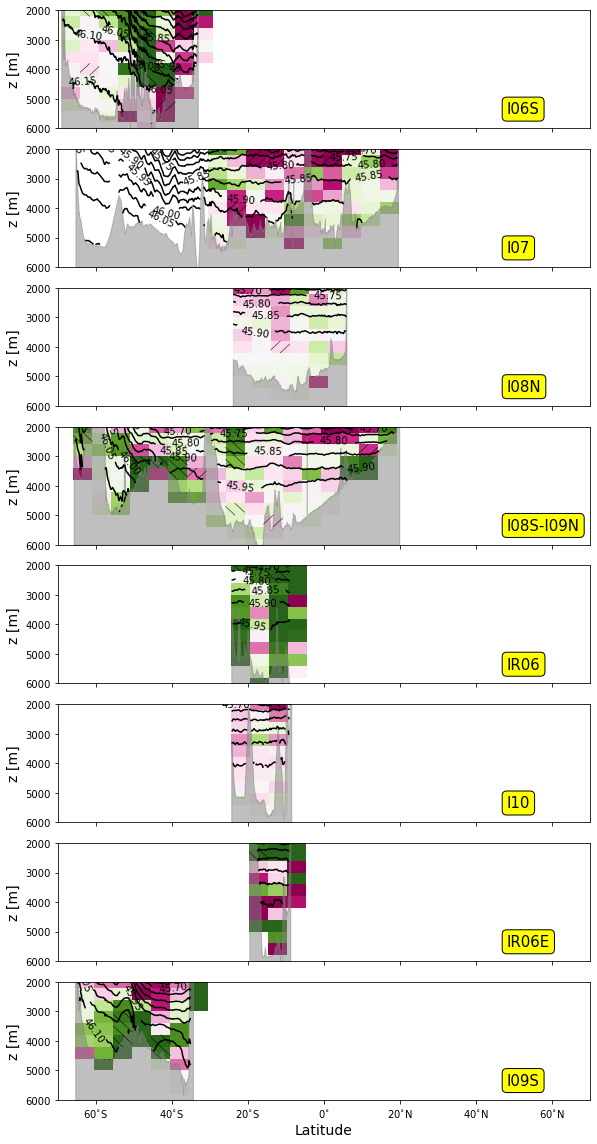

In [28]:
fig, ax = plt.subplots(nrows=len(lon_sec), ncols=1, figsize=(140/100*6, len(lon_sec)*2), sharex=True)
for i in range(len(lon_sec)):
    acquisition = lon_sec[i]
    Data = xr.open_dataset(datafilepath + acquisition.lower() + ".nc")
    Data_trend = xr.open_dataset(datafilepath + acquisition.lower() + "_trend.nc")
    Data_trend_sig4 = xr.open_dataset(datafilepath+ acquisition.lower() + "_sig4_trend.nc")
    
    plot_N2_trend_z(Data_trend, ax[i], np.diff(Data_trend.LL_st)[0], np.diff(Data_trend.z_N2)[0], vrange=param_plot['vlim1'], yrange=[param_plot['z1_lw'], param_plot['z1_up']])
    cs = ax[i].contour(Data.LL, Data.z_N2, np.nanmean(Data.Sig4_N2,axis=0).T, levels=np.arange(param_plot['sig1_up'], param_plot['sig1_lw'], .05),colors='k',linewidth='.5')
    ax[i].clabel(cs, cs.levels, fmt ='%1.2f',  inline=True, fontsize=10)        
#     ax[i].set_title(acquisition, fontsize=15)
    ax[i].text(48, 5500, acquisition, fontsize=15, bbox=dict(boxstyle='round', facecolor='yellow'))
    ax[i].set_ylabel('z [m]', fontsize=14)
    ax[i].set_xlim([-70, 70])
    ax[i].set_xticks(np.arange(-60, 60+1, 20))
    if i == len(lon_sec)-1:
        ax[i].set_xticklabels(['60$^{\circ}$S','40$^{\circ}$S','20$^{\circ}$S','0$^{\circ}$',
                            '20$^{\circ}$N','40$^{\circ}$N','60$^{\circ}$N'])
        ax[i].set_xlabel('Latitude', fontsize=14)
    if lon_sec[i].startswith('S'):
        loc_ll, dep_ll = loc_dep_sec(lon_sec[i], method_sec, datafilepath_sec+'southern/')
    else:
        loc_ll, dep_ll = loc_dep_sec(lon_sec[i], method_sec, datafilepath_sec+'indian/')
    ax[i].fill_between(loc_ll, dep_ll, param_plot['z1_lw'], color='.5', alpha=.5)


plt.tight_layout()
plt.savefig(outfilepath+ 'Indian_meridional_N2trend.jpeg', dpi=300)
plt.savefig(outfilepath+ 'Indian_meridional_N2trend.eps')

### 2. latitudinal sections

In [29]:
# latitudinal sections
lat_sec = ['I01', 'I02', 'I03-I04', 'I05', 'S04I']
method_sec = 0

/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/4202119098.py:7: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  ax.pcolormesh(np.hstack([data_N2_trend.LL_st.data,data_N2_trend.LL_st.data[-1]+dl]),
/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/2793965298.py:9: RuntimeWarning: Mean of empty slice
  cs = ax[i].contour(Data.LL, Data.z_N2, np.nanmean(Data.Sig4_N2,axis=0).T, levels=np.arange(param_plot['sig1_up'], param_plot['sig1_lw'], .05),colors='k',linewidth='.5')
/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/2793965298.py:9: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cs = ax[i].contour(Data.LL, Data.z_N2, np.nanmean(Data.Sig4_N2,axis=0).T, levels=np.arange(param_plot['sig1_up'], param_plot['sig1_lw'], .05),colors='k',linewidth='.5'

---------- I01 ----------


/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/2793965298.py:9: RuntimeWarning: Mean of empty slice
  cs = ax[i].contour(Data.LL, Data.z_N2, np.nanmean(Data.Sig4_N2,axis=0).T, levels=np.arange(param_plot['sig1_up'], param_plot['sig1_lw'], .05),colors='k',linewidth='.5')
/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/2793965298.py:9: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cs = ax[i].contour(Data.LL, Data.z_N2, np.nanmean(Data.Sig4_N2,axis=0).T, levels=np.arange(param_plot['sig1_up'], param_plot['sig1_lw'], .05),colors='k',linewidth='.5')
/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/4202119098.py:7: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  ax.pcolormesh(np.hstack([data_N2_trend.LL_st.data,data_N2_trend.LL_st.data[-1]+dl])

---------- I02 ----------


/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/2793965298.py:9: RuntimeWarning: Mean of empty slice
  cs = ax[i].contour(Data.LL, Data.z_N2, np.nanmean(Data.Sig4_N2,axis=0).T, levels=np.arange(param_plot['sig1_up'], param_plot['sig1_lw'], .05),colors='k',linewidth='.5')
/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/2793965298.py:9: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cs = ax[i].contour(Data.LL, Data.z_N2, np.nanmean(Data.Sig4_N2,axis=0).T, levels=np.arange(param_plot['sig1_up'], param_plot['sig1_lw'], .05),colors='k',linewidth='.5')


---------- I03-I04 ----------


/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/4202119098.py:7: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  ax.pcolormesh(np.hstack([data_N2_trend.LL_st.data,data_N2_trend.LL_st.data[-1]+dl]),
/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/2793965298.py:9: RuntimeWarning: Mean of empty slice
  cs = ax[i].contour(Data.LL, Data.z_N2, np.nanmean(Data.Sig4_N2,axis=0).T, levels=np.arange(param_plot['sig1_up'], param_plot['sig1_lw'], .05),colors='k',linewidth='.5')
/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/2793965298.py:9: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cs = ax[i].contour(Data.LL, Data.z_N2, np.nanmean(Data.Sig4_N2,axis=0).T, levels=np.arange(param_plot['sig1_up'], param_plot['sig1_lw'], .05),colors='k',linewidth='.5'

---------- I05 ----------


/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/4202119098.py:7: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  ax.pcolormesh(np.hstack([data_N2_trend.LL_st.data,data_N2_trend.LL_st.data[-1]+dl]),
/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/2793965298.py:9: RuntimeWarning: Mean of empty slice
  cs = ax[i].contour(Data.LL, Data.z_N2, np.nanmean(Data.Sig4_N2,axis=0).T, levels=np.arange(param_plot['sig1_up'], param_plot['sig1_lw'], .05),colors='k',linewidth='.5')
/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/2793965298.py:9: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cs = ax[i].contour(Data.LL, Data.z_N2, np.nanmean(Data.Sig4_N2,axis=0).T, levels=np.arange(param_plot['sig1_up'], param_plot['sig1_lw'], .05),colors='k',linewidth='.5'

---------- S04I ----------


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

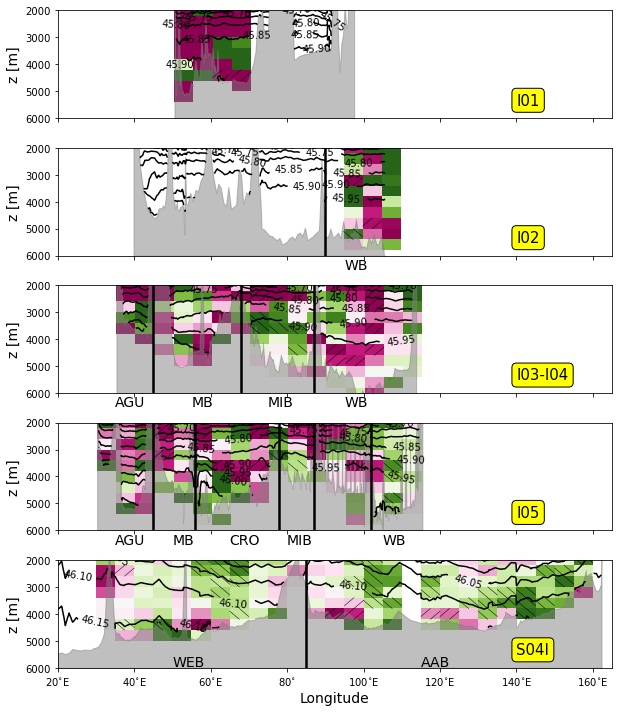

In [30]:
fig, ax = plt.subplots(nrows=len(lat_sec), ncols=1, figsize=(145/100*6, len(lat_sec)*2), sharex=True)
for i in range(len(lat_sec)):
    acquisition = lat_sec[i]
    Data = xr.open_dataset(datafilepath + acquisition.lower() + ".nc")
    Data_trend = xr.open_dataset(datafilepath + acquisition.lower() + "_trend.nc")
    Data_trend_sig4 = xr.open_dataset(datafilepath+ acquisition.lower() + "_sig4_trend.nc")
    
    plot_N2_trend_z(Data_trend, ax[i], np.diff(Data_trend.LL_st)[0], np.diff(Data_trend.z_N2)[0], vrange=param_plot['vlim1'], yrange=[param_plot['z1_lw'], param_plot['z1_up']])
    cs = ax[i].contour(Data.LL, Data.z_N2, np.nanmean(Data.Sig4_N2,axis=0).T, levels=np.arange(param_plot['sig1_up'], param_plot['sig1_lw'], .05),colors='k',linewidth='.5')
    ax[i].clabel(cs, cs.levels, fmt ='%1.2f',  inline=True, fontsize=10)
#     ax[i].set_title(acquisition, fontsize=15)
    ax[i].text(140, 5500, acquisition, fontsize=15, bbox=dict(boxstyle='round', facecolor='yellow'))
    ax[i].set_ylabel('z [m]', fontsize=14)
    ax[i].set_xlim([20, 165])
    ax[i].set_xticks(np.arange(20, 165, 20))
    if i == len(lat_sec)-1:
        ax[i].set_xticklabels(['20$^{\circ}$E','40$^{\circ}$E','60$^{\circ}$E','80$^{\circ}$',
                               '100$^{\circ}$E', '120$^{\circ}$E', '140$^{\circ}$E', '160$^{\circ}$E'])
        ax[i].set_xlabel('Longitude', fontsize=14)
    if lat_sec[i].startswith('S'):
        loc_ll, dep_ll = loc_dep_sec(lat_sec[i], method_sec, datafilepath_sec+'southern/')
        loc_ll[loc_ll>180]-=360
    else:
        loc_ll, dep_ll = loc_dep_sec(lat_sec[i], method_sec, datafilepath_sec+'indian/')
        loc_ll[loc_ll>180]-=360
    ax[i].fill_between(loc_ll, dep_ll, param_plot['z1_lw'], color='.5', alpha=.5)

ax[-1].plot([85, 85], [2000, 6000], 'k', lw=2.5)
ax[-1].text(50, 5950, 'WEB', fontsize=14)
ax[-1].text(115, 5950, 'AAB', fontsize=14)
ax[-2].plot([45, 45], [2000, 6000], 'k', lw=2.5)
ax[-2].plot([56, 56], [2000, 6000], 'k', lw=2.5)
ax[-2].plot([78, 78], [2000, 6000], 'k', lw=2.5)
ax[-2].plot([87, 87], [2000, 6000], 'k', lw=2.5)
ax[-2].plot([102, 102], [2000, 6000], 'k', lw=2.5)
ax[-2].text(35, 6500, 'AGU', fontsize=14)
ax[-2].text(50, 6500, 'MB', fontsize=14)
ax[-2].text(65, 6500, 'CRO', fontsize=14)
ax[-2].text(80, 6500, 'MIB', fontsize=14)
ax[-2].text(105, 6500, 'WB', fontsize=14)
ax[-3].plot([45, 45], [2000, 6000], 'k', lw=2.5)
ax[-3].plot([68, 68], [2000, 6000], 'k', lw=2.5)
ax[-3].plot([87, 87], [2000, 6000], 'k', lw=2.5)
ax[-3].text(35, 6500, 'AGU', fontsize=14)
ax[-3].text(55, 6500, 'MB', fontsize=14)
ax[-3].text(75, 6500, 'MIB', fontsize=14)
ax[-3].text(95, 6500, 'WB', fontsize=14)
ax[-4].plot([90, 90], [2000, 6000], 'k', lw=2.5)
ax[-4].text(95, 6500, 'WB', fontsize=14)

plt.tight_layout()
plt.savefig(outfilepath+ 'Indian_zonal_N2trend.jpeg', dpi=300)
plt.savefig(outfilepath+ 'Indian_zonal_N2trend.eps')

/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/4202119098.py:31: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  ax.pcolormesh(np.hstack([data_N2_trend.LL_st.data,data_N2_trend.LL_st.data[-1]+dl]),
/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/4202119098.py:31: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  ax.pcolormesh(np.hstack([data_N2_trend.LL_st.data,data_N2_trend.LL_st.data[-1]+dl]),
/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/4202119098.py:31: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two min

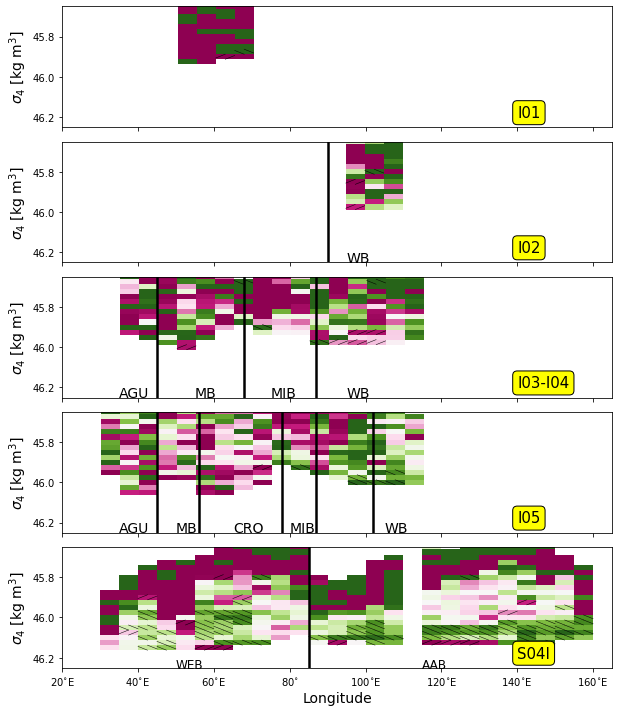

In [31]:
fig, ax = plt.subplots(nrows=len(lat_sec), ncols=1, figsize=(145/100*6, len(lat_sec)*2), sharex=True)
for i in range(len(lat_sec)):
    acquisition = lat_sec[i]
    Data_trend = xr.open_dataset(datafilepath + acquisition.lower() + "_trend.nc")
    Data_trend_sig4 = xr.open_dataset(datafilepath+ acquisition.lower() + "_sig4_trend.nc")

    
    plot_N2_trend_sig(Data_trend_sig4, ax[i], np.diff(Data_trend_sig4.LL_st)[0], np.diff(Data_trend_sig4.z_N2)[0], vrange=param_plot['vlim1'], yrange=[param_plot['sig1_lw'], param_plot['sig1_up']])

#     ax[i].set_title(acquisition, fontsize=15)
    ax[i].text(140, 46.2, acquisition, fontsize=15, bbox=dict(boxstyle='round', facecolor='yellow'))
    ax[i].set_ylabel('$\sigma_4$ [kg m$^3$]', fontsize=14)
    ax[i].set_xlim([20, 165])
    ax[i].set_xticks(np.arange(20, 165, 20))
    if i == len(lat_sec)-1:
        ax[i].set_xticklabels(['20$^{\circ}$E','40$^{\circ}$E','60$^{\circ}$E','80$^{\circ}$',
                               '100$^{\circ}$E', '120$^{\circ}$E', '140$^{\circ}$E', '160$^{\circ}$E'])
        ax[i].set_xlabel('Longitude', fontsize=14)

ax[-1].plot([85, 85], [param_plot['sig1_lw'], param_plot['sig1_up']], 'k', lw=2.5)
ax[-1].text(50, param_plot['sig1_lw'], 'WEB', fontsize=12)
ax[-1].text(115, param_plot['sig1_lw'], 'AAB', fontsize=12)
ax[-2].plot([45, 45], [param_plot['sig1_lw'], param_plot['sig1_up']], 'k', lw=2.5)
ax[-2].plot([56, 56], [param_plot['sig1_lw'], param_plot['sig1_up']], 'k', lw=2.5)
ax[-2].plot([78, 78], [param_plot['sig1_lw'], param_plot['sig1_up']], 'k', lw=2.5)
ax[-2].plot([87, 87], [param_plot['sig1_lw'], param_plot['sig1_up']], 'k', lw=2.5)
ax[-2].plot([102, 102], [param_plot['sig1_lw'], param_plot['sig1_up']], 'k', lw=2.5)
ax[-2].text(35, param_plot['sig1_lw'], 'AGU', fontsize=14)
ax[-2].text(50, param_plot['sig1_lw'], 'MB', fontsize=14)
ax[-2].text(65, param_plot['sig1_lw'], 'CRO', fontsize=14)
ax[-2].text(80, param_plot['sig1_lw'], 'MIB', fontsize=14)
ax[-2].text(105, param_plot['sig1_lw'], 'WB', fontsize=14)
ax[-3].plot([45, 45], [param_plot['sig1_lw'], param_plot['sig1_up']], 'k', lw=2.5)
ax[-3].plot([68, 68], [param_plot['sig1_lw'], param_plot['sig1_up']], 'k', lw=2.5)
ax[-3].plot([87, 87], [param_plot['sig1_lw'], param_plot['sig1_up']], 'k', lw=2.5)
ax[-3].text(35, param_plot['sig1_lw'], 'AGU', fontsize=14)
ax[-3].text(55, param_plot['sig1_lw'], 'MB', fontsize=14)
ax[-3].text(75, param_plot['sig1_lw'], 'MIB', fontsize=14)
ax[-3].text(95, param_plot['sig1_lw'], 'WB', fontsize=14)
ax[-4].plot([90, 90], [param_plot['sig1_lw'], param_plot['sig1_up']], 'k', lw=2.5)
ax[-4].text(95, param_plot['sig1_lw'], 'WB', fontsize=14)

plt.tight_layout()
plt.savefig(outfilepath+ 'Indian_zonal_N2trend_sigma.jpeg', dpi=300)
plt.savefig(outfilepath+ 'Indian_zonal_N2trend_sigma.eps')

## All meridonal

In [32]:
# longitudial sections
lon_sec = ['I06S', 'I08S-I09N', 'I09S', 'SR03', 'P14', 'P15', 'P16', 'P17E', 'P18', 'A16-A23', 'A13', 'A12']
method_sec = 1


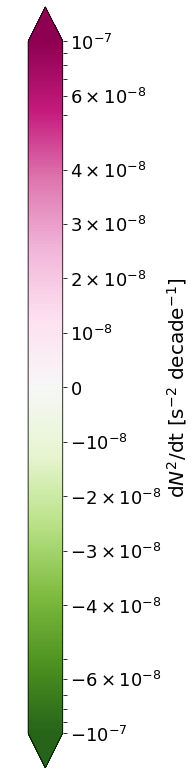

In [33]:
import matplotlib as mpl
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(2.5, 14))

fraction = 1  # .05

norm = mpl.colors.SymLogNorm(linthresh=5e-8, vmax=param_plot['vlim1'][-1], vmin=param_plot['vlim1'][0], base=10)
cbar = ax.figure.colorbar(
            mpl.cm.ScalarMappable(norm=norm, cmap='PiYG_r'),
            ax=ax, pad=.15, extend='both', fraction=fraction, orientation="vertical")
cbar.ax.tick_params(labelsize=18)
cbar.set_label(label='d$N^2$/dt [s$^{-2}$ decade$^{-1}$]', fontsize=param_pic['fontsize'][1])

ax.axis('off')
plt.savefig(outfilepath+ 'N2trend_colorbar_vertical.jpeg', dpi=300)
plt.savefig(outfilepath+ 'N2trend_colorbar_vertical.eps')


/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/4202119098.py:7: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  ax.pcolormesh(np.hstack([data_N2_trend.LL_st.data,data_N2_trend.LL_st.data[-1]+dl]),
/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/1667705909.py:9: RuntimeWarning: Mean of empty slice
  cs = ax[i].contour(Data.LL, Data.z_N2, np.nanmean(Data.Sig4_N2,axis=0).T, levels=np.arange(param_plot['sig1_up'], param_plot['sig1_lw'], .05),colors='k',linewidth='.5')
/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/1667705909.py:9: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cs = ax[i].contour(Data.LL, Data.z_N2, np.nanmean(Data.Sig4_N2,axis=0).T, levels=np.arange(param_plot['sig1_up'], param_plot['sig1_lw'], .05),colors='k',linewidth='.5'

---------- I06S ----------


/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/4202119098.py:7: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  ax.pcolormesh(np.hstack([data_N2_trend.LL_st.data,data_N2_trend.LL_st.data[-1]+dl]),
/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/1667705909.py:9: RuntimeWarning: Mean of empty slice
  cs = ax[i].contour(Data.LL, Data.z_N2, np.nanmean(Data.Sig4_N2,axis=0).T, levels=np.arange(param_plot['sig1_up'], param_plot['sig1_lw'], .05),colors='k',linewidth='.5')
/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/1667705909.py:9: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cs = ax[i].contour(Data.LL, Data.z_N2, np.nanmean(Data.Sig4_N2,axis=0).T, levels=np.arange(param_plot['sig1_up'], param_plot['sig1_lw'], .05),colors='k',linewidth='.5'

---------- I08S-I09N ----------


/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/4202119098.py:7: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  ax.pcolormesh(np.hstack([data_N2_trend.LL_st.data,data_N2_trend.LL_st.data[-1]+dl]),
/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/1667705909.py:9: RuntimeWarning: Mean of empty slice
  cs = ax[i].contour(Data.LL, Data.z_N2, np.nanmean(Data.Sig4_N2,axis=0).T, levels=np.arange(param_plot['sig1_up'], param_plot['sig1_lw'], .05),colors='k',linewidth='.5')
/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/1667705909.py:9: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cs = ax[i].contour(Data.LL, Data.z_N2, np.nanmean(Data.Sig4_N2,axis=0).T, levels=np.arange(param_plot['sig1_up'], param_plot['sig1_lw'], .05),colors='k',linewidth='.5'

---------- I09S ----------


/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/4202119098.py:7: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  ax.pcolormesh(np.hstack([data_N2_trend.LL_st.data,data_N2_trend.LL_st.data[-1]+dl]),
/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/1667705909.py:9: RuntimeWarning: Mean of empty slice
  cs = ax[i].contour(Data.LL, Data.z_N2, np.nanmean(Data.Sig4_N2,axis=0).T, levels=np.arange(param_plot['sig1_up'], param_plot['sig1_lw'], .05),colors='k',linewidth='.5')
/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/1667705909.py:9: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cs = ax[i].contour(Data.LL, Data.z_N2, np.nanmean(Data.Sig4_N2,axis=0).T, levels=np.arange(param_plot['sig1_up'], param_plot['sig1_lw'], .05),colors='k',linewidth='.5'

---------- SR03 ----------


/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/4202119098.py:7: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  ax.pcolormesh(np.hstack([data_N2_trend.LL_st.data,data_N2_trend.LL_st.data[-1]+dl]),
/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/1667705909.py:9: RuntimeWarning: Mean of empty slice
  cs = ax[i].contour(Data.LL, Data.z_N2, np.nanmean(Data.Sig4_N2,axis=0).T, levels=np.arange(param_plot['sig1_up'], param_plot['sig1_lw'], .05),colors='k',linewidth='.5')
/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/1667705909.py:9: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cs = ax[i].contour(Data.LL, Data.z_N2, np.nanmean(Data.Sig4_N2,axis=0).T, levels=np.arange(param_plot['sig1_up'], param_plot['sig1_lw'], .05),colors='k',linewidth='.5'

---------- P14 ----------


/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/4202119098.py:7: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  ax.pcolormesh(np.hstack([data_N2_trend.LL_st.data,data_N2_trend.LL_st.data[-1]+dl]),
/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/1667705909.py:9: RuntimeWarning: Mean of empty slice
  cs = ax[i].contour(Data.LL, Data.z_N2, np.nanmean(Data.Sig4_N2,axis=0).T, levels=np.arange(param_plot['sig1_up'], param_plot['sig1_lw'], .05),colors='k',linewidth='.5')
/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/1667705909.py:9: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cs = ax[i].contour(Data.LL, Data.z_N2, np.nanmean(Data.Sig4_N2,axis=0).T, levels=np.arange(param_plot['sig1_up'], param_plot['sig1_lw'], .05),colors='k',linewidth='.5'

---------- P15 ----------


/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/4202119098.py:7: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  ax.pcolormesh(np.hstack([data_N2_trend.LL_st.data,data_N2_trend.LL_st.data[-1]+dl]),
/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/1667705909.py:9: RuntimeWarning: Mean of empty slice
  cs = ax[i].contour(Data.LL, Data.z_N2, np.nanmean(Data.Sig4_N2,axis=0).T, levels=np.arange(param_plot['sig1_up'], param_plot['sig1_lw'], .05),colors='k',linewidth='.5')
/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/1667705909.py:9: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cs = ax[i].contour(Data.LL, Data.z_N2, np.nanmean(Data.Sig4_N2,axis=0).T, levels=np.arange(param_plot['sig1_up'], param_plot['sig1_lw'], .05),colors='k',linewidth='.5'

---------- P16 ----------


/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/4202119098.py:7: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  ax.pcolormesh(np.hstack([data_N2_trend.LL_st.data,data_N2_trend.LL_st.data[-1]+dl]),
/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/1667705909.py:9: RuntimeWarning: Mean of empty slice
  cs = ax[i].contour(Data.LL, Data.z_N2, np.nanmean(Data.Sig4_N2,axis=0).T, levels=np.arange(param_plot['sig1_up'], param_plot['sig1_lw'], .05),colors='k',linewidth='.5')
/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/1667705909.py:9: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cs = ax[i].contour(Data.LL, Data.z_N2, np.nanmean(Data.Sig4_N2,axis=0).T, levels=np.arange(param_plot['sig1_up'], param_plot['sig1_lw'], .05),colors='k',linewidth='.5'

---------- P17E ----------


/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/1667705909.py:9: RuntimeWarning: Mean of empty slice
  cs = ax[i].contour(Data.LL, Data.z_N2, np.nanmean(Data.Sig4_N2,axis=0).T, levels=np.arange(param_plot['sig1_up'], param_plot['sig1_lw'], .05),colors='k',linewidth='.5')
/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/1667705909.py:9: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cs = ax[i].contour(Data.LL, Data.z_N2, np.nanmean(Data.Sig4_N2,axis=0).T, levels=np.arange(param_plot['sig1_up'], param_plot['sig1_lw'], .05),colors='k',linewidth='.5')


---------- P18 ----------


/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/4202119098.py:7: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  ax.pcolormesh(np.hstack([data_N2_trend.LL_st.data,data_N2_trend.LL_st.data[-1]+dl]),
/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/1667705909.py:9: RuntimeWarning: Mean of empty slice
  cs = ax[i].contour(Data.LL, Data.z_N2, np.nanmean(Data.Sig4_N2,axis=0).T, levels=np.arange(param_plot['sig1_up'], param_plot['sig1_lw'], .05),colors='k',linewidth='.5')
/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/1667705909.py:9: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cs = ax[i].contour(Data.LL, Data.z_N2, np.nanmean(Data.Sig4_N2,axis=0).T, levels=np.arange(param_plot['sig1_up'], param_plot['sig1_lw'], .05),colors='k',linewidth='.5'

---------- A16-A23 ----------


/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/4202119098.py:7: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  ax.pcolormesh(np.hstack([data_N2_trend.LL_st.data,data_N2_trend.LL_st.data[-1]+dl]),
/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/1667705909.py:9: RuntimeWarning: Mean of empty slice
  cs = ax[i].contour(Data.LL, Data.z_N2, np.nanmean(Data.Sig4_N2,axis=0).T, levels=np.arange(param_plot['sig1_up'], param_plot['sig1_lw'], .05),colors='k',linewidth='.5')
/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/1667705909.py:9: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cs = ax[i].contour(Data.LL, Data.z_N2, np.nanmean(Data.Sig4_N2,axis=0).T, levels=np.arange(param_plot['sig1_up'], param_plot['sig1_lw'], .05),colors='k',linewidth='.5'

---------- A13 ----------


/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/4202119098.py:7: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  ax.pcolormesh(np.hstack([data_N2_trend.LL_st.data,data_N2_trend.LL_st.data[-1]+dl]),
/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/1667705909.py:9: RuntimeWarning: Mean of empty slice
  cs = ax[i].contour(Data.LL, Data.z_N2, np.nanmean(Data.Sig4_N2,axis=0).T, levels=np.arange(param_plot['sig1_up'], param_plot['sig1_lw'], .05),colors='k',linewidth='.5')
/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/1667705909.py:9: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cs = ax[i].contour(Data.LL, Data.z_N2, np.nanmean(Data.Sig4_N2,axis=0).T, levels=np.arange(param_plot['sig1_up'], param_plot['sig1_lw'], .05),colors='k',linewidth='.5'

---------- A12 ----------


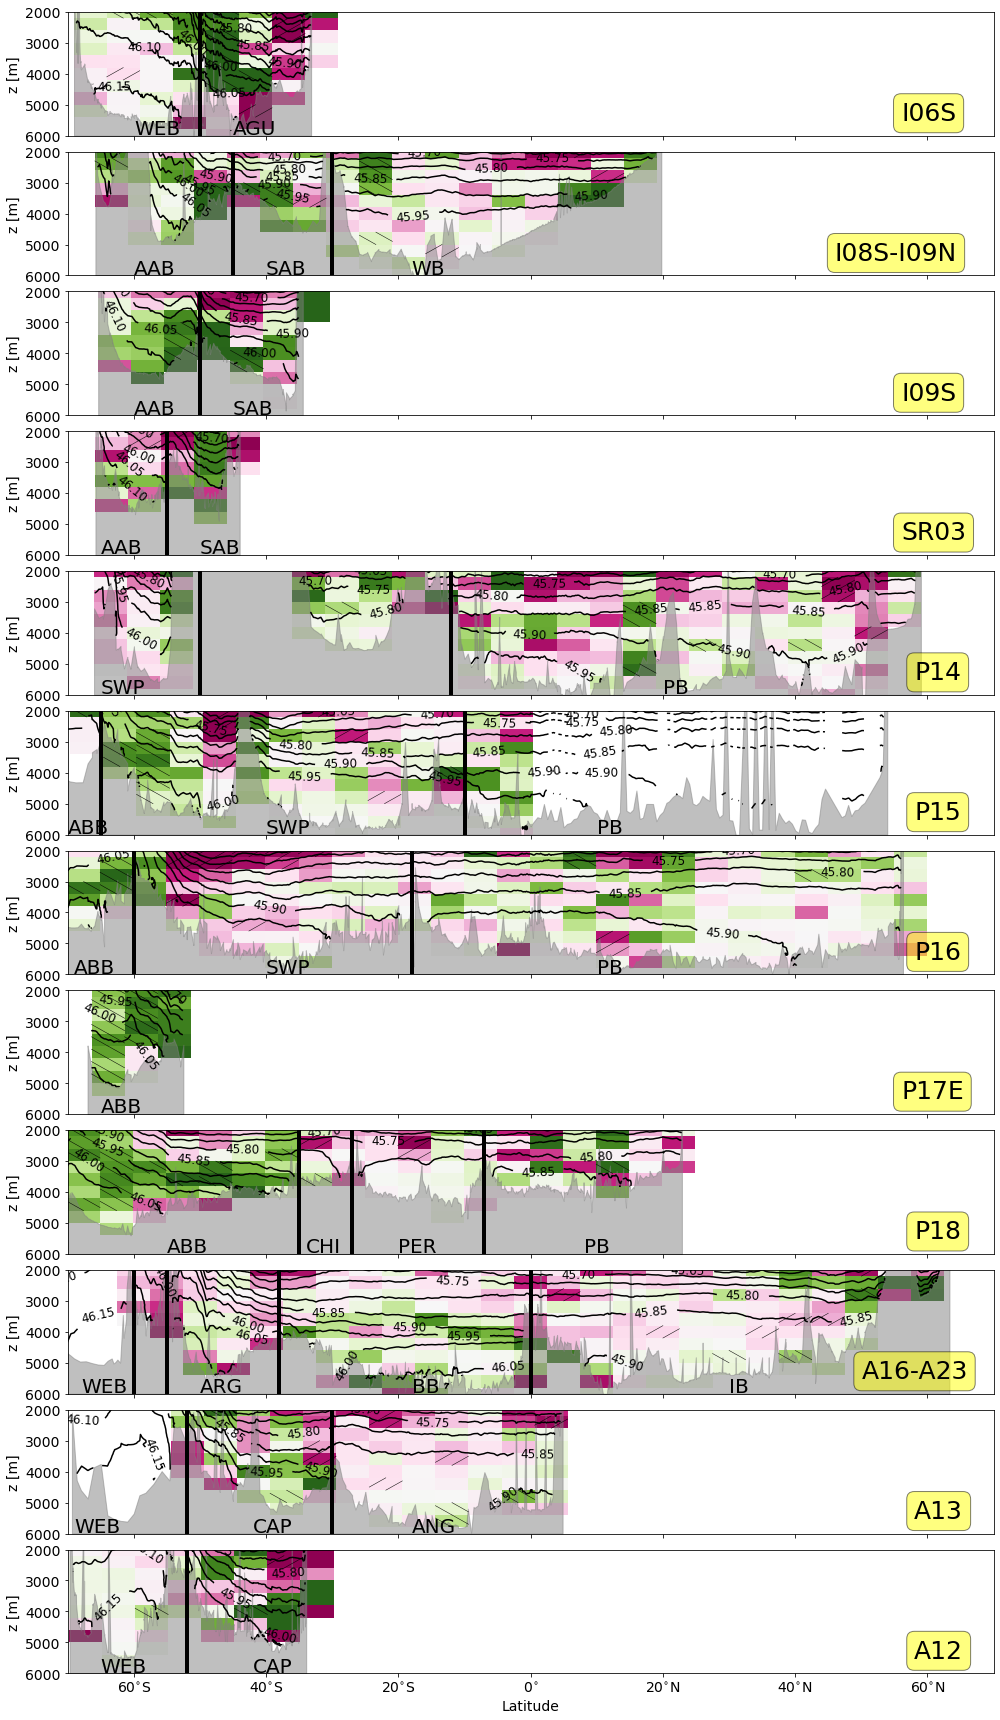

In [34]:
fig, ax = plt.subplots(nrows=len(lon_sec), ncols=1, figsize=(140/100*10, len(lon_sec)*2), sharex=True)
for i in range(len(lon_sec)):
    acquisition = lon_sec[i]
    Data = xr.open_dataset(datafilepath + acquisition.lower() + ".nc")
    Data_trend = xr.open_dataset(datafilepath + acquisition.lower() + "_trend.nc")
    Data_trend_sig4 = xr.open_dataset(datafilepath+ acquisition.lower() + "_sig4_trend.nc")
    
    plot_N2_trend_z(Data_trend, ax[i], np.diff(Data_trend.LL_st)[0], np.diff(Data_trend.z_N2)[0], vrange=param_plot['vlim1'], yrange=[param_plot['z1_lw'], param_plot['z1_up']])
    cs = ax[i].contour(Data.LL, Data.z_N2, np.nanmean(Data.Sig4_N2,axis=0).T, levels=np.arange(param_plot['sig1_up'], param_plot['sig1_lw'], .05),colors='k',linewidth='.5')
    ax[i].clabel(cs, cs.levels, fmt ='%1.2f',  inline=True, fontsize=12)        
#     ax[i].set_title(acquisition, fontsize=15)
    ax[i].text(64-2*len(lon_sec[i]), 5500, acquisition, fontsize=param_pic['fontsize'][-1], bbox=dict(boxstyle='round', facecolor='yellow', alpha=.5))
    ax[i].set_ylabel('z [m]', fontsize=param_pic['fontsize'][0])
    ax[i].set_xlim([-70, 70])
    ax[i].set_xticks(np.arange(-60, 60+1, 20))
    if i == len(lon_sec)-1:
        ax[i].set_xticklabels(['60$^{\circ}$S','40$^{\circ}$S','20$^{\circ}$S','0$^{\circ}$',
                            '20$^{\circ}$N','40$^{\circ}$N','60$^{\circ}$N'])
        ax[i].set_xlabel('Latitude', fontsize=param_pic['fontsize'][0])
    if lon_sec[i].startswith('S'):
        loc_ll, dep_ll = loc_dep_sec(lon_sec[i], method_sec, datafilepath_sec+'southern/')
    elif lon_sec[i].startswith('I'):
        loc_ll, dep_ll = loc_dep_sec(lon_sec[i], method_sec, datafilepath_sec+'indian/')
    elif lon_sec[i].startswith('P'):
        loc_ll, dep_ll = loc_dep_sec(lon_sec[i], method_sec, datafilepath_sec+'pacific/')
    elif lon_sec[i].startswith('A'):
        loc_ll, dep_ll = loc_dep_sec(lon_sec[i], method_sec, datafilepath_sec+'atlantic/')
    else:
        break
    ax[i].fill_between(loc_ll, dep_ll, param_plot['z1_lw'], color='.5', alpha=.5)
    ax[i].tick_params(axis='both', which='major', labelsize=param_pic['fontsize'][0])
#     ax[i].set_rasterized(True)


ax[0].text(-60, 5950, 'WEB', fontsize=param_pic['fontsize'][1])
ax[0].plot([-50, -50], [2000, 6000], 'k', lw=param_pic['linewidth'][-1])
ax[0].text(-45, 5950, 'AGU', fontsize=param_pic['fontsize'][1])

ax[1].text(-60, 5950, 'AAB', fontsize=param_pic['fontsize'][1])
ax[1].plot([-45, -45], [2000, 6000], 'k', lw=param_pic['linewidth'][-1])
ax[1].text(-40, 5950, 'SAB', fontsize=param_pic['fontsize'][1])
ax[1].plot([-30, -30], [2000, 6000], 'k', lw=param_pic['linewidth'][-1])
ax[1].text(-18, 5950, 'WB', fontsize=param_pic['fontsize'][1])

ax[2].text(-60, 5950, 'AAB', fontsize=param_pic['fontsize'][1])
ax[2].plot([-50, -50], [2000, 6000], 'k', lw=param_pic['linewidth'][-1])
ax[2].text(-45, 5950, 'SAB', fontsize=param_pic['fontsize'][1])

ax[3].text(-65, 5950, 'AAB', fontsize=param_pic['fontsize'][1])
ax[3].plot([-55, -55], [2000, 6000], 'k', lw=param_pic['linewidth'][-1])
ax[3].text(-50, 5950, 'SAB', fontsize=param_pic['fontsize'][1])

ax[4].text(-65, 5950, 'SWP', fontsize=param_pic['fontsize'][1])
ax[4].plot([-50, -50], [2000, 6000], 'k', lw=param_pic['linewidth'][-1])
ax[4].text(20, 5950, 'PB', fontsize=param_pic['fontsize'][1])
ax[4].plot([-12, -12], [2000, 6000], 'k', lw=param_pic['linewidth'][-1])

ax[5].text(-70, 5950, 'ABB', fontsize=param_pic['fontsize'][1])
ax[5].plot([-65, -65], [2000, 6000], 'k', lw=param_pic['linewidth'][-1])
ax[5].text(-40, 5950, 'SWP', fontsize=param_pic['fontsize'][1])
ax[5].plot([-10, -10], [2000, 6000], 'k', lw=param_pic['linewidth'][-1])
ax[5].text(10, 5950, 'PB', fontsize=param_pic['fontsize'][1])

ax[6].text(-69, 5950, 'ABB', fontsize=param_pic['fontsize'][1])
ax[6].plot([-60, -60], [2000, 6000], 'k', lw=param_pic['linewidth'][-1])
ax[6].text(-40, 5950, 'SWP', fontsize=param_pic['fontsize'][1])
ax[6].plot([-18, -18], [2000, 6000], 'k', lw=param_pic['linewidth'][-1])
ax[6].text(10, 5950, 'PB', fontsize=param_pic['fontsize'][1])

ax[7].text(-65, 5950, 'ABB', fontsize=param_pic['fontsize'][1])

ax[8].text(-55, 5950, 'ABB', fontsize=param_pic['fontsize'][1])
ax[8].plot([-35, -35], [2000, 6000], 'k', lw=param_pic['linewidth'][-1])
ax[8].text(-34, 5950, 'CHI', fontsize=param_pic['fontsize'][1])
ax[8].plot([-27, -27], [2000, 6000], 'k', lw=param_pic['linewidth'][-1])
ax[8].text(-20, 5950, 'PER', fontsize=param_pic['fontsize'][1])
ax[8].plot([-7, -7], [2000, 6000], 'k', lw=param_pic['linewidth'][-1])
ax[8].text(8, 5950, 'PB', fontsize=param_pic['fontsize'][1])

ax[9].text(-68, 5950, 'WEB', fontsize=param_pic['fontsize'][1])
ax[9].plot([-60, -60], [2000, 6000], 'k', lw=param_pic['linewidth'][-1])
ax[9].plot([-55, -55], [2000, 6000], 'k', lw=param_pic['linewidth'][-1])
ax[9].text(-50, 5950, 'ARG', fontsize=param_pic['fontsize'][1])
ax[9].plot([-38, -38], [2000, 6000], 'k', lw=param_pic['linewidth'][-1])
ax[9].text(-18, 5950, 'BB', fontsize=param_pic['fontsize'][1])
ax[9].plot([0, 0], [2000, 6000], 'k', lw=param_pic['linewidth'][-1])
ax[9].text(30, 5950, 'IB', fontsize=param_pic['fontsize'][1])

ax[10].text(-69, 5950, 'WEB', fontsize=param_pic['fontsize'][1])
ax[10].plot([-52, -52], [2000, 6000], 'k', lw=param_pic['linewidth'][-1])
ax[10].text(-42, 5950, 'CAP', fontsize=param_pic['fontsize'][1])
ax[10].plot([-30, -30], [2000, 6000], 'k', lw=param_pic['linewidth'][-1])
ax[10].text(-18, 5950, 'ANG', fontsize=param_pic['fontsize'][1])

ax[-1].text(-65, 5950, 'WEB', fontsize=param_pic['fontsize'][1])
ax[-1].plot([-52, -52], [2000, 6000], 'k', lw=param_pic['linewidth'][-1])
# ax[-1].text(-52, 5950, 'AGU', fontsize=param_pic['fontsize'][1])
# ax[-1].plot([-45, -45], [2000, 6000], 'k', lw=param_pic['linewidth'][-1])
ax[-1].text(-42, 5950, 'CAP', fontsize=param_pic['fontsize'][1])

plt.tight_layout(h_pad=.2)
plt.savefig(outfilepath+ 'all_meridional_N2trend.jpeg', dpi=300)
# plt.savefig(outfilepath+ 'all_meridional_N2trend.eps')

## All zonal

In [35]:
# latitudinal sections
lat_sec = [['','I01', 'I02', 'I03-I04', 'I05', 'S04I'], ['P01', 'P02', 'P03', 'P21', 'P06', 'S04P'], ['75N', 'AR07E', 'A02', 'A05', 'A10', 'SR04']]
method_sec = 0

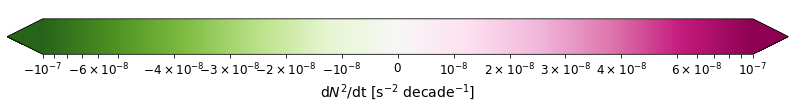

In [36]:
import matplotlib as mpl
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(14,1.5))
# fig, ax = plt.subplots(1, 1, figsize=(6,1))

fraction = 1  # .05

norm = mpl.colors.SymLogNorm(linthresh=5e-8, vmax=param_plot['vlim1'][-1], vmin=param_plot['vlim1'][0], base=10)
cbar = ax.figure.colorbar(
            mpl.cm.ScalarMappable(norm=norm, cmap='PiYG_r'),
            ax=ax, pad=.15, extend='both', fraction=fraction, orientation="horizontal")
cbar.ax.tick_params(labelsize=12)
cbar.set_label(label='d$N^2$/dt [s$^{-2}$ decade$^{-1}$]', fontsize=14)

ax.axis('off')
plt.savefig(outfilepath+ 'N2trend_colorbar.jpeg', dpi=300)
plt.savefig(outfilepath+ 'N2trend_colorbar.eps')


/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/4202119098.py:7: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  ax.pcolormesh(np.hstack([data_N2_trend.LL_st.data,data_N2_trend.LL_st.data[-1]+dl]),
/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/2397808822.py:20: RuntimeWarning: Mean of empty slice
  cs = ax[i,ii].contour(Data.LL, Data.z_N2, np.nanmean(Data.Sig4_N2,axis=0).T, levels=np.arange(param_plot['sig1_up'], param_plot['sig1_lw'], .05),colors='k',linewidth='.5')
/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/2397808822.py:20: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cs = ax[i,ii].contour(Data.LL, Data.z_N2, np.nanmean(Data.Sig4_N2,axis=0).T, levels=np.arange(param_plot['sig1_up'], param_plot['sig1_lw'], .05),colors='k',linewi

---------- I01 ----------


/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/2397808822.py:20: RuntimeWarning: Mean of empty slice
  cs = ax[i,ii].contour(Data.LL, Data.z_N2, np.nanmean(Data.Sig4_N2,axis=0).T, levels=np.arange(param_plot['sig1_up'], param_plot['sig1_lw'], .05),colors='k',linewidth='.5')
/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/2397808822.py:20: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cs = ax[i,ii].contour(Data.LL, Data.z_N2, np.nanmean(Data.Sig4_N2,axis=0).T, levels=np.arange(param_plot['sig1_up'], param_plot['sig1_lw'], .05),colors='k',linewidth='.5')
/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/4202119098.py:7: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  ax.pcolormesh(np.hstack([data_N2_trend.LL_st.data,data_N2_trend.LL_st.data[

---------- I02 ----------


/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/2397808822.py:20: RuntimeWarning: Mean of empty slice
  cs = ax[i,ii].contour(Data.LL, Data.z_N2, np.nanmean(Data.Sig4_N2,axis=0).T, levels=np.arange(param_plot['sig1_up'], param_plot['sig1_lw'], .05),colors='k',linewidth='.5')
/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/2397808822.py:20: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cs = ax[i,ii].contour(Data.LL, Data.z_N2, np.nanmean(Data.Sig4_N2,axis=0).T, levels=np.arange(param_plot['sig1_up'], param_plot['sig1_lw'], .05),colors='k',linewidth='.5')


---------- I03-I04 ----------


/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/4202119098.py:7: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  ax.pcolormesh(np.hstack([data_N2_trend.LL_st.data,data_N2_trend.LL_st.data[-1]+dl]),
/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/2397808822.py:20: RuntimeWarning: Mean of empty slice
  cs = ax[i,ii].contour(Data.LL, Data.z_N2, np.nanmean(Data.Sig4_N2,axis=0).T, levels=np.arange(param_plot['sig1_up'], param_plot['sig1_lw'], .05),colors='k',linewidth='.5')
/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/2397808822.py:20: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cs = ax[i,ii].contour(Data.LL, Data.z_N2, np.nanmean(Data.Sig4_N2,axis=0).T, levels=np.arange(param_plot['sig1_up'], param_plot['sig1_lw'], .05),colors='k',linewi

---------- I05 ----------


/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/4202119098.py:7: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  ax.pcolormesh(np.hstack([data_N2_trend.LL_st.data,data_N2_trend.LL_st.data[-1]+dl]),
/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/2397808822.py:20: RuntimeWarning: Mean of empty slice
  cs = ax[i,ii].contour(Data.LL, Data.z_N2, np.nanmean(Data.Sig4_N2,axis=0).T, levels=np.arange(param_plot['sig1_up'], param_plot['sig1_lw'], .05),colors='k',linewidth='.5')
/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/2397808822.py:20: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cs = ax[i,ii].contour(Data.LL, Data.z_N2, np.nanmean(Data.Sig4_N2,axis=0).T, levels=np.arange(param_plot['sig1_up'], param_plot['sig1_lw'], .05),colors='k',linewi

---------- S04I ----------


/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/4202119098.py:7: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  ax.pcolormesh(np.hstack([data_N2_trend.LL_st.data,data_N2_trend.LL_st.data[-1]+dl]),
/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/2397808822.py:20: RuntimeWarning: Mean of empty slice
  cs = ax[i,ii].contour(Data.LL, Data.z_N2, np.nanmean(Data.Sig4_N2,axis=0).T, levels=np.arange(param_plot['sig1_up'], param_plot['sig1_lw'], .05),colors='k',linewidth='.5')
/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/2397808822.py:20: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cs = ax[i,ii].contour(Data.LL, Data.z_N2, np.nanmean(Data.Sig4_N2,axis=0).T, levels=np.arange(param_plot['sig1_up'], param_plot['sig1_lw'], .05),colors='k',linewi

---------- P01 ----------


/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/4202119098.py:7: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  ax.pcolormesh(np.hstack([data_N2_trend.LL_st.data,data_N2_trend.LL_st.data[-1]+dl]),
/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/2397808822.py:20: RuntimeWarning: Mean of empty slice
  cs = ax[i,ii].contour(Data.LL, Data.z_N2, np.nanmean(Data.Sig4_N2,axis=0).T, levels=np.arange(param_plot['sig1_up'], param_plot['sig1_lw'], .05),colors='k',linewidth='.5')
/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/2397808822.py:20: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cs = ax[i,ii].contour(Data.LL, Data.z_N2, np.nanmean(Data.Sig4_N2,axis=0).T, levels=np.arange(param_plot['sig1_up'], param_plot['sig1_lw'], .05),colors='k',linewi

---------- P02 ----------


/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/4202119098.py:7: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  ax.pcolormesh(np.hstack([data_N2_trend.LL_st.data,data_N2_trend.LL_st.data[-1]+dl]),
/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/2397808822.py:20: RuntimeWarning: Mean of empty slice
  cs = ax[i,ii].contour(Data.LL, Data.z_N2, np.nanmean(Data.Sig4_N2,axis=0).T, levels=np.arange(param_plot['sig1_up'], param_plot['sig1_lw'], .05),colors='k',linewidth='.5')
/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/2397808822.py:20: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cs = ax[i,ii].contour(Data.LL, Data.z_N2, np.nanmean(Data.Sig4_N2,axis=0).T, levels=np.arange(param_plot['sig1_up'], param_plot['sig1_lw'], .05),colors='k',linewi

---------- P03 ----------


/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/4202119098.py:7: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  ax.pcolormesh(np.hstack([data_N2_trend.LL_st.data,data_N2_trend.LL_st.data[-1]+dl]),
/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/2397808822.py:20: RuntimeWarning: Mean of empty slice
  cs = ax[i,ii].contour(Data.LL, Data.z_N2, np.nanmean(Data.Sig4_N2,axis=0).T, levels=np.arange(param_plot['sig1_up'], param_plot['sig1_lw'], .05),colors='k',linewidth='.5')
/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/2397808822.py:20: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cs = ax[i,ii].contour(Data.LL, Data.z_N2, np.nanmean(Data.Sig4_N2,axis=0).T, levels=np.arange(param_plot['sig1_up'], param_plot['sig1_lw'], .05),colors='k',linewi

---------- P21 ----------


/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/4202119098.py:7: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  ax.pcolormesh(np.hstack([data_N2_trend.LL_st.data,data_N2_trend.LL_st.data[-1]+dl]),
/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/2397808822.py:20: RuntimeWarning: Mean of empty slice
  cs = ax[i,ii].contour(Data.LL, Data.z_N2, np.nanmean(Data.Sig4_N2,axis=0).T, levels=np.arange(param_plot['sig1_up'], param_plot['sig1_lw'], .05),colors='k',linewidth='.5')
/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/2397808822.py:20: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cs = ax[i,ii].contour(Data.LL, Data.z_N2, np.nanmean(Data.Sig4_N2,axis=0).T, levels=np.arange(param_plot['sig1_up'], param_plot['sig1_lw'], .05),colors='k',linewi

---------- P06 ----------


/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/4202119098.py:7: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  ax.pcolormesh(np.hstack([data_N2_trend.LL_st.data,data_N2_trend.LL_st.data[-1]+dl]),
/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/2397808822.py:20: RuntimeWarning: Mean of empty slice
  cs = ax[i,ii].contour(Data.LL, Data.z_N2, np.nanmean(Data.Sig4_N2,axis=0).T, levels=np.arange(param_plot['sig1_up'], param_plot['sig1_lw'], .05),colors='k',linewidth='.5')
/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/2397808822.py:20: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cs = ax[i,ii].contour(Data.LL, Data.z_N2, np.nanmean(Data.Sig4_N2,axis=0).T, levels=np.arange(param_plot['sig1_up'], param_plot['sig1_lw'], .05),colors='k',linewi

---------- S04P ----------


/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/2397808822.py:20: RuntimeWarning: Mean of empty slice
  cs = ax[i,ii].contour(Data.LL, Data.z_N2, np.nanmean(Data.Sig4_N2,axis=0).T, levels=np.arange(param_plot['sig1_up'], param_plot['sig1_lw'], .05),colors='k',linewidth='.5')
/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/2397808822.py:20: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cs = ax[i,ii].contour(Data.LL, Data.z_N2, np.nanmean(Data.Sig4_N2,axis=0).T, levels=np.arange(param_plot['sig1_up'], param_plot['sig1_lw'], .05),colors='k',linewidth='.5')
/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/2397808822.py:36: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i,ii].set_yticklabels(['', '', '', '',''])


---------- 75N ----------


/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/4202119098.py:7: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  ax.pcolormesh(np.hstack([data_N2_trend.LL_st.data,data_N2_trend.LL_st.data[-1]+dl]),
/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/2397808822.py:20: RuntimeWarning: Mean of empty slice
  cs = ax[i,ii].contour(Data.LL, Data.z_N2, np.nanmean(Data.Sig4_N2,axis=0).T, levels=np.arange(param_plot['sig1_up'], param_plot['sig1_lw'], .05),colors='k',linewidth='.5')
/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/2397808822.py:20: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cs = ax[i,ii].contour(Data.LL, Data.z_N2, np.nanmean(Data.Sig4_N2,axis=0).T, levels=np.arange(param_plot['sig1_up'], param_plot['sig1_lw'], .05),colors='k',linewi

---------- AR07E ----------


/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/4202119098.py:7: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  ax.pcolormesh(np.hstack([data_N2_trend.LL_st.data,data_N2_trend.LL_st.data[-1]+dl]),
/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/2397808822.py:20: RuntimeWarning: Mean of empty slice
  cs = ax[i,ii].contour(Data.LL, Data.z_N2, np.nanmean(Data.Sig4_N2,axis=0).T, levels=np.arange(param_plot['sig1_up'], param_plot['sig1_lw'], .05),colors='k',linewidth='.5')
/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/2397808822.py:20: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cs = ax[i,ii].contour(Data.LL, Data.z_N2, np.nanmean(Data.Sig4_N2,axis=0).T, levels=np.arange(param_plot['sig1_up'], param_plot['sig1_lw'], .05),colors='k',linewi

---------- A02 ----------


/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/4202119098.py:7: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  ax.pcolormesh(np.hstack([data_N2_trend.LL_st.data,data_N2_trend.LL_st.data[-1]+dl]),
/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/2397808822.py:20: RuntimeWarning: Mean of empty slice
  cs = ax[i,ii].contour(Data.LL, Data.z_N2, np.nanmean(Data.Sig4_N2,axis=0).T, levels=np.arange(param_plot['sig1_up'], param_plot['sig1_lw'], .05),colors='k',linewidth='.5')
/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/2397808822.py:20: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cs = ax[i,ii].contour(Data.LL, Data.z_N2, np.nanmean(Data.Sig4_N2,axis=0).T, levels=np.arange(param_plot['sig1_up'], param_plot['sig1_lw'], .05),colors='k',linewi

---------- A05 ----------


/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/4202119098.py:7: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  ax.pcolormesh(np.hstack([data_N2_trend.LL_st.data,data_N2_trend.LL_st.data[-1]+dl]),
/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/2397808822.py:20: RuntimeWarning: Mean of empty slice
  cs = ax[i,ii].contour(Data.LL, Data.z_N2, np.nanmean(Data.Sig4_N2,axis=0).T, levels=np.arange(param_plot['sig1_up'], param_plot['sig1_lw'], .05),colors='k',linewidth='.5')
/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/2397808822.py:20: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cs = ax[i,ii].contour(Data.LL, Data.z_N2, np.nanmean(Data.Sig4_N2,axis=0).T, levels=np.arange(param_plot['sig1_up'], param_plot['sig1_lw'], .05),colors='k',linewi

---------- A10 ----------


/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/4202119098.py:7: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  ax.pcolormesh(np.hstack([data_N2_trend.LL_st.data,data_N2_trend.LL_st.data[-1]+dl]),
/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/2397808822.py:20: RuntimeWarning: Mean of empty slice
  cs = ax[i,ii].contour(Data.LL, Data.z_N2, np.nanmean(Data.Sig4_N2,axis=0).T, levels=np.arange(param_plot['sig1_up'], param_plot['sig1_lw'], .05),colors='k',linewidth='.5')
/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_25199/2397808822.py:20: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cs = ax[i,ii].contour(Data.LL, Data.z_N2, np.nanmean(Data.Sig4_N2,axis=0).T, levels=np.arange(param_plot['sig1_up'], param_plot['sig1_lw'], .05),colors='k',linewi

---------- SR04 ----------


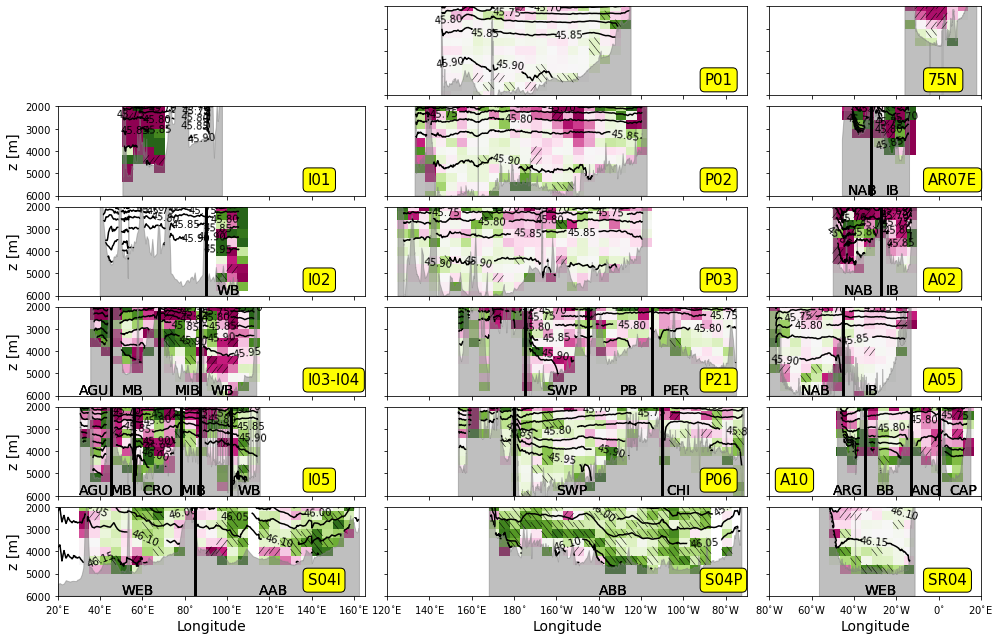

In [37]:
fig, ax = plt.subplots(nrows=len(lat_sec[1]), ncols=len(lat_sec), figsize=(14, len(lat_sec)*3), gridspec_kw={'width_ratios': [145, 170, 100]})
for ii in range(len(lat_sec)):
    for i in range(len(lat_sec[ii])):
        acquisition = lat_sec[ii][i]
        if len(acquisition)>0:
            Data = xr.open_dataset(datafilepath + acquisition.lower() + ".nc")
            Data_trend = xr.open_dataset(datafilepath + acquisition.lower() + "_trend.nc")
            Data_trend_sig4 = xr.open_dataset(datafilepath+ acquisition.lower() + "_sig4_trend.nc")
            
            if ii == 2:
                ll_st = Data_trend.LL_st.data
                ll = Data.LL.data
                ll_st[ll_st>180] -= 360 
                ll[ll>180] -= 360 
                Data = Data.assign_coords(LL=ll)
                Data_trend = Data_trend.assign_coords(LL_st=ll_st)
                Data_trend_sig4 = Data_trend_sig4.assign_coords(LL_st=ll_st)    
        
            plot_N2_trend_z(Data_trend, ax[i,ii], np.diff(Data_trend.LL_st)[0], np.diff(Data_trend.z_N2)[0], vrange=param_plot['vlim1'], yrange=[param_plot['z1_lw'], param_plot['z1_up']])
            cs = ax[i,ii].contour(Data.LL, Data.z_N2, np.nanmean(Data.Sig4_N2,axis=0).T, levels=np.arange(param_plot['sig1_up'], param_plot['sig1_lw'], .05),colors='k',linewidth='.5')
            ax[i,ii].clabel(cs, cs.levels, fmt ='%1.2f',  inline=True, fontsize=10)
        #     ax[i,ii].set_title(acquisition, fontsize=15)
            if ii == 0:
                ax[i,ii].text(140-2, 5500, acquisition, fontsize=15, bbox=dict(boxstyle='round', facecolor='yellow'))
            elif ii == 1:
                ax[i,ii].text(270, 5500, acquisition, fontsize=15, bbox=dict(boxstyle='round', facecolor='yellow'))
            else:
                if i == 4:
                    ax[i,ii].text(-75, 5500, acquisition, fontsize=15, bbox=dict(boxstyle='round', facecolor='yellow'))
                else:
                    ax[i,ii].text(-5, 5500, acquisition, fontsize=15, bbox=dict(boxstyle='round', facecolor='yellow'))

            if ii == 0:
                ax[i,ii].set_ylabel('z [m]', fontsize=14)
            else:
                ax[i,ii].set_yticklabels(['', '', '', '',''])
                
            if ii == 0:
                ax[i,ii].set_xlim([20, 165])
                ax[i,ii].set_xticks(np.arange(20, 165, 20))
                if i == len(lat_sec[ii])-1:
                    ax[i,ii].set_xticklabels(['20$^{\circ}$E','40$^{\circ}$E','60$^{\circ}$E','80$^{\circ}$',
                                           '100$^{\circ}$E', '120$^{\circ}$E', '140$^{\circ}$E', '160$^{\circ}$E'])
                    ax[i,ii].set_xlabel('Longitude', fontsize=14)
                else:
                    ax[i,ii].set_xticklabels(['','','','','','','',''])                
            elif ii == 1:
                ax[i,ii].set_xlim([120, 290])
                ax[i,ii].set_xticks(np.arange(120, 290, 20))
                if i == len(lat_sec[ii])-1:
                    ax[i,ii].set_xticklabels(['120$^{\circ}$E','140$^{\circ}$E','160$^{\circ}$E','180$^{\circ}$',
                                           '160$^{\circ}$W', '140$^{\circ}$W', '120$^{\circ}$W', '100$^{\circ}$W', '80$^{\circ}$W'])
                    ax[i,ii].set_xlabel('Longitude', fontsize=14)      
                else:
                    ax[i,ii].set_xticklabels(['','','','','','','','',''])
            else:
                ax[i,ii].set_xlim([-80, 20])
                ax[i,ii].set_xticks(np.arange(-80, 20+1, 20))            
                if i == len(lat_sec[ii])-1:
                    ax[i,ii].set_xticklabels(['80$^{\circ}$W','60$^{\circ}$W','40$^{\circ}$W','20$^{\circ}$W',
                                           '0$^{\circ}$', '20$^{\circ}$E'])
                    ax[i,ii].set_xlabel('Longitude', fontsize=14)
                else:
                    ax[i,ii].set_xticklabels(['','','','','',''])

            if (ii == 0) & (lat_sec[ii][i].startswith('S')):
                loc_ll, dep_ll = loc_dep_sec(lat_sec[ii][i], method_sec, datafilepath_sec+'southern/')
                loc_ll[loc_ll>180]-=360
            elif (ii == 0) & (lat_sec[ii][i].startswith('I')):
                loc_ll, dep_ll = loc_dep_sec(lat_sec[ii][i], method_sec, datafilepath_sec+'indian/')
                loc_ll[loc_ll>180]-=360
            elif (ii == 1) & (lat_sec[ii][i].startswith('S')):
                loc_ll, dep_ll = loc_dep_sec(lat_sec[ii][i], method_sec, datafilepath_sec+'southern/')
            elif (ii == 1) & (lat_sec[ii][i].startswith('P')):
                loc_ll, dep_ll = loc_dep_sec(lat_sec[ii][i], method_sec, datafilepath_sec+'pacific/')
            elif (ii == 2) & (lat_sec[ii][i].startswith('S')):
                loc_ll, dep_ll = loc_dep_sec(lat_sec[ii][i], method_sec, datafilepath_sec+'southern/')
                loc_ll[loc_ll>180]-=360
            else:
                loc_ll, dep_ll = loc_dep_sec(lat_sec[ii][i], method_sec, datafilepath_sec+'atlantic/')
                loc_ll[loc_ll>180]-=360

            ax[i,ii].fill_between(loc_ll, dep_ll, param_plot['z1_lw'], color='.5', alpha=.5)
        else:
            ax[i,ii].axis('off')
        
    ax[-1,0].plot([85, 85], [2000, 6000], 'k', lw=2.5)
    ax[-1,0].text(50, 5950, 'WEB', fontsize=14)
    ax[-1,0].text(115, 5950, 'AAB', fontsize=14)
    ax[-2,0].plot([45, 45], [2000, 6000], 'k', lw=2.5)
    ax[-2,0].plot([56, 56], [2000, 6000], 'k', lw=2.5)
    ax[-2,0].plot([78, 78], [2000, 6000], 'k', lw=2.5)
    ax[-2,0].plot([87, 87], [2000, 6000], 'k', lw=2.5)
    ax[-2,0].plot([102, 102], [2000, 6000], 'k', lw=2.5)
    ax[-2,0].text(30, 5950, 'AGU', fontsize=14)
    ax[-2,0].text(45, 5950, 'MB', fontsize=14)
    ax[-2,0].text(60, 5950, 'CRO', fontsize=14)
    ax[-2,0].text(78, 5950, 'MIB', fontsize=14)
    ax[-2,0].text(105, 5950, 'WB', fontsize=14)
    ax[-3,0].plot([45, 45], [2000, 6000], 'k', lw=2.5)
    ax[-3,0].plot([68, 68], [2000, 6000], 'k', lw=2.5)
    ax[-3,0].plot([87, 87], [2000, 6000], 'k', lw=2.5)
    ax[-3,0].text(30, 5950, 'AGU', fontsize=14)
    ax[-3,0].text(50, 5950, 'MB', fontsize=14)
    ax[-3,0].text(75, 5950, 'MIB', fontsize=14)
    ax[-3,0].text(92, 5950, 'WB', fontsize=14)
    ax[-4,0].plot([90, 90], [2000, 6000], 'k', lw=2.5)
    ax[-4,0].text(95, 5950, 'WB', fontsize=14)
    
    ax[-1,1].text(220, 5950, 'ABB', fontsize=14)
    ax[-2,1].plot([180, 180], [2000, 6000], 'k', lw=2.5)
    ax[-2,1].plot([250, 250], [2000, 6000], 'k', lw=2.5)
    ax[-2,1].text(200, 5950, 'SWP', fontsize=14)
    ax[-2,1].text(252, 5950, 'CHI', fontsize=14)
    ax[-3,1].plot([185, 185], [2000, 6000], 'k', lw=2.5)
    ax[-3,1].plot([215, 215], [2000, 6000], 'k', lw=2.5)
    ax[-3,1].plot([245, 245], [2000, 6000], 'k', lw=2.5)
    ax[-3,1].text(195, 5950, 'SWP', fontsize=14)
    ax[-3,1].text(230, 5950, 'PB', fontsize=14)
    ax[-3,1].text(250, 5950, 'PER', fontsize=14)
   
    ax[-1,-1].text(-35, 5950, 'WEB', fontsize=14)
    ax[-2,-1].plot([-35, -35], [2000, 6000], 'k', lw=2.5)
    ax[-2,-1].plot([-13, -13], [2000, 6000], 'k', lw=2.5)
    ax[-2,-1].plot([0, 0], [2000, 6000], 'k', lw=2.5)
    ax[-2,-1].text(-50, 5950, 'ARG', fontsize=14)
    ax[-2,-1].text(-30, 5950, 'BB', fontsize=14)
    ax[-2,-1].text(-13, 5950, 'ANG', fontsize=14)
    ax[-2,-1].text(5, 5950, 'CAP', fontsize=14)
    ax[-3,-1].plot([-45, -45], [2000, 6000], 'k', lw=2.5)
    ax[-3,-1].text(-65, 5950, 'NAB', fontsize=14)
    ax[-3,-1].text(-35, 5950, 'IB', fontsize=14)
    ax[2,-1].plot([-27, -27], [2000, 6000], 'k', lw=2.5)
    ax[2,-1].text(-45, 5950, 'NAB', fontsize=14)
    ax[2,-1].text(-25, 5950, 'IB', fontsize=14)
    ax[1,-1].plot([-32, -32], [2000, 6000], 'k', lw=2.5)
    ax[1,-1].text(-43, 5950, 'NAB', fontsize=14)
    ax[1,-1].text(-25, 5950, 'IB', fontsize=14)

plt.tight_layout(h_pad=.1, w_pad=-.1)
plt.savefig(outfilepath+ 'all_zonal_N2trend.jpeg', dpi=300)
# plt.savefig(outfilepath+ 'all_zonal_N2trend.eps')

## Compare TS

In [38]:
Data = xr.open_dataset('/Users/stan/Desktop/WORK/DATA/GOSHIP/EasyOcean/gridded/p02.nc')
Data

<xarray.Dataset>
Dimensions:   (LL: 1098, N_Occup: 3, Pressure: 651, z_N2: 163)
Coordinates:
  * Pressure  (Pressure) uint16 0 10 20 30 40 50 ... 6460 6470 6480 6490 6500
  * N_Occup   (N_Occup) int64 1 2 3
  * LL        (LL) float64 133.0 133.1 133.2 133.3 ... 242.4 242.5 242.6 242.7
  * z_N2      (z_N2) uint16 0 40 80 120 160 200 ... 6320 6360 6400 6440 6480
Data variables:
    SA        (N_Occup, LL, Pressure) float64 ...
    CT        (N_Occup, LL, Pressure) float64 ...
    Sig4      (N_Occup, LL, Pressure) float64 ...
    N2        (N_Occup, LL, z_N2) float64 ...
    Sig4_N2   (N_Occup, LL, z_N2) float64 ...
    CT_N2     (N_Occup, LL, z_N2) float64 ...
    SA_N2     (N_Occup, LL, z_N2) float64 ...
    time      (N_Occup, LL) datetime64[ns] ...
Attributes:
    title:    converted EasyOcean gridded data, z_N2 is pressure

(34.86, 34.89)

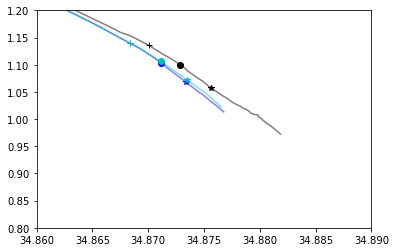

In [39]:
colors = ['k', 'b', 'c', 'y', 'pink', 'r', 'purple']
for i in range(len(Data.N_Occup)):
#     for j in range(len(Data.LL)):
#         plt.plot(Data.SA_N2[i,j,:].data, Data.CT_N2[i,j,:].data, linewidth=.5, color=colors[i], alpha=.5)
    plt.plot(Data.SA_N2[i,:,:].mean(axis=0).data, Data.CT_N2[i,:,:].mean(axis=0).data, '-', color=colors[i], alpha=.5)
for i in range(len(Data.N_Occup)):
#     for j in range(len(Data.LL)):
#         plt.plot(Data.SA_N2[i,j,:].sel(z_N2=4000).data, Data.CT_N2[i,j,:].sel(z_N2=4000).data, 'o', color=colors[i])
    plt.plot(Data.SA_N2[i,:,:].mean(axis=0).sel(z_N2=4600).data, Data.CT_N2[i,:,:].mean(axis=0).sel(z_N2=4600).data, 'o', color=colors[i])
    plt.plot(Data.SA_N2[i,:,:].mean(axis=0).sel(z_N2=4200).data, Data.CT_N2[i,:,:].mean(axis=0).sel(z_N2=4200).data, '+', color=colors[i])
    plt.plot(Data.SA_N2[i,:,:].mean(axis=0).sel(z_N2=5000).data, Data.CT_N2[i,:,:].mean(axis=0).sel(z_N2=5000).data, '*', color=colors[i])

plt.ylim([.8,1.2])
plt.xlim([34.86, 34.89])

(34.87, 35.0)

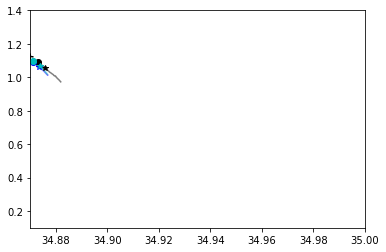

In [40]:
colors = ['k', 'b', 'c', 'y', 'pink', 'r', 'purple']
for i in range(len(Data.N_Occup)):
#     for j in range(len(Data.LL)):
#         plt.plot(Data.SA_N2[i,j,:].data, Data.CT_N2[i,j,:].data, linewidth=.5, color=colors[i], alpha=.5)
    plt.plot(Data.SA_N2[i,:700,:].mean(axis=0).data, Data.CT_N2[i,:700,:].mean(axis=0).data, '-', color=colors[i], alpha=.5)
for i in range(len(Data.N_Occup)):
#     for j in range(len(Data.LL)):
#         plt.plot(Data.SA_N2[i,j,:].sel(z_N2=4000).data, Data.CT_N2[i,j,:].sel(z_N2=4000).data, 'o', color=colors[i])
    plt.plot(Data.SA_N2[i,:700,:].mean(axis=0).sel(z_N2=4600).data, Data.CT_N2[i,:700,:].mean(axis=0).sel(z_N2=4600).data, 'o', color=colors[i])
    plt.plot(Data.SA_N2[i,:700,:].mean(axis=0).sel(z_N2=4200).data, Data.CT_N2[i,:700,:].mean(axis=0).sel(z_N2=4200).data, '+', color=colors[i])
    plt.plot(Data.SA_N2[i,:700,:].mean(axis=0).sel(z_N2=5000).data, Data.CT_N2[i,:700,:].mean(axis=0).sel(z_N2=5000).data, '*', color=colors[i])

plt.ylim([.1,1.4])
plt.xlim([34.87, 35])